# Instruções
#### objetivo geral: criar uma rede neural para classificação de imagens do dataset fashion mnist e exploração de todas as características da rede neural, uma por vez.
O melhor resultado de cada questão/etapa é utilizado nas próximas

### QUESTÃO 01: exploração inicial
- Dataset fashion mnist
- função de ativação
- 5 testes com inicialização aleatória: diferenças de convergencia, estabilidade e desempenho
- dataset de treino
- métricas: medida de desempenho(accuracy), função de perda (entropia cruzada/loss), curva de convergência
- otimizador: Adam
- arquitetura: quantas camadas e neurônios por camada
- funcoes de ativação: ReLU, Sigmoid ou Tanh
- quantas épocas
- taxa de aprendizado
- indícios de under/overfitting

### QUESTÃO 02: exploração de hiperparâmetros
- taxa de aprendizado x termo momento x velocidade de convergência
- Grid search para encontrar a melhor combinação: erro de treinamento x taxa de aprendizado x momento
- taxa de aprendizado menor e momento intermediário
- dataset de treino e (opcionalmente) dataset de validação
- métricas: função de perda, velocidade de convergência, curva de convergência e (opcional) estabilidade
- critério de parada
- combinação com melhor equilíbrio entre velocidadee estabilidade
- tendências observadas(ex: maior taxa de aprendizado leva a maior velocidade, mas menor estabilidade)

### QUESTÃO 03: topologia de rede neural
- dataset de treino e (opcionalmente) dataset de validação
- impacto do número de camadas ocultas e neurônios por camada e teste de variação desses números
- métricas: função de perda, curva de convergência(under e overfitting), tempo de treinamento, generalização(medida F), precisão, revocação
- gráfico de perda mostrando diferença entre topologias

### QUESTÃO 04: qualidade dos dados
- influência do número e qualidade dos dados, ruído, etc sobre a capacidade de generalização
- dividir o dataset em subsets de acordo com o rótulo -> manter proporcionalidade
- faixas do dataset: 10%, 30%, 50%, 70%, 100%
- métrica: função de perda, acurácia,
- identificar saturação no aprendizado
- curvas de generalização: tamanho do conjunto X desempenho
- tempo de treinamento e custo computacional
- Estratégia de amostragem(estratificada, aleatória ou outra)

### QUESTÃO 05:
- escolher 4 melhores modelos e usar modelo de testes neles
- treinamento como referência comparativa
- ajustes de otimização
- métricas: perda(entropia cruzada categórica), acurácia, curva de validação(treinamento x teste), F1 score, precisão, revocação
- escolha da configuração final do modelo

### QUESTÃO 06: validação cruzada k-fold
divisão do dataset em k-subconjuntos e teste em todos eles
- métricas: média de todas as partições de perda: acurácia e F1.
- para cada partição: curvas de validação e variância(dispersão) dos resultados
- justificativa do tamanho de k
- identificação de flutuações
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow import kerasimpor
from tensorflow import keras
from sklearn.model_selection import train_test_split
import secrets
import pickle
from pathlib import Path
import time
import gc
from tensorflow.keras.callbacks import EarlyStopping

# Divisão do dataset

In [4]:
#dataset já dividido em treino e teste
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#split de treino entre 80% treino e 20% validação
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train) #20% do treino vira validação. stratify=Y mantém a proporção das classes
# Normalização (0-1) para visualização e futura modelagem
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0
"""
converte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0
redes neurais funcionam melhor com entradas contínuas e escala pequena e próxima
float representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)
y é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização
"""

'\nconverte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0\nredes neurais funcionam melhor com entradas contínuas e escala pequena e próxima\nfloat representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)\ny é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização\n'

# vizualização do dataset Fashion-MNIST

Treino: (48000, 28, 28), Validação: (12000, 28, 28), Teste: (10000, 28, 28)
Exemplo de rótulos (0-9): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


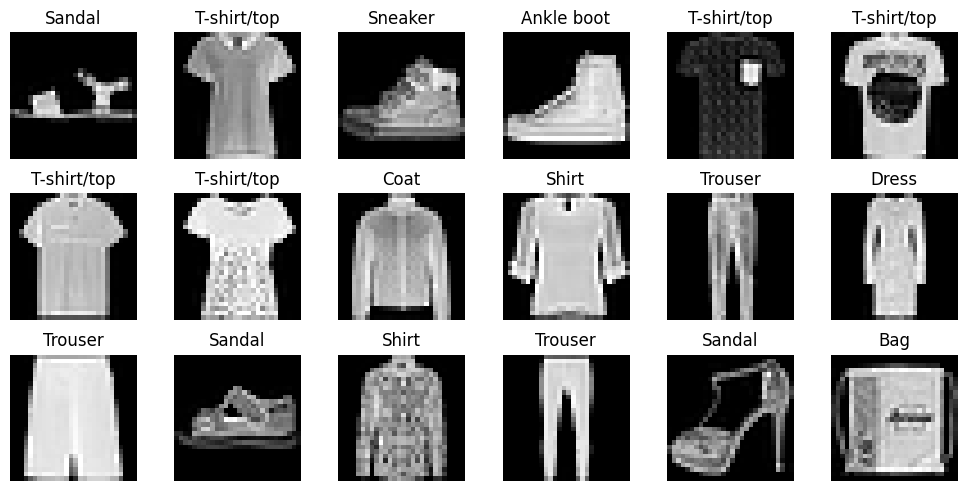

In [5]:
labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Treino: {x_train.shape}, Validação: {x_val.shape}, Teste: {x_test.shape}")
print("Exemplo de rótulos (0-9):", labels)

# Grid de amostras aleatórias do conjunto de treino
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0, len(x_train))
    ax.imshow(x_train[idx], cmap="gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.tight_layout()
plt.show()

### Modelo

In [6]:
"""
configuração padrão:
    camada de entrada com 784 neurônios(cada pixel da imagem 28x28)
    2 camadas ocultas (64 e 32 neurônios)
    camada de saída com 10 neurônios (10 classes)
"""

def build_model(learning_rate=1e-3, beta1=0.9, activation_hidden = 'relu', activation_output = 'softmax', num_hidden_layers=2, neurons_per_layer=[64, 32]):

    layers = [
        keras.layers.InputLayer(shape=(28, 28)),  # imagens 28x28 pixels, cada pixel é um neurônio de entrada
        keras.layers.Flatten()  # transforma matriz 2D 28x28 em vetor 1D com 784 elementos
    ]
    # adiciona dinamicamente as camadas ocultas conforme num_hidden_layers
    for i in range(num_hidden_layers):
        layers.append(keras.layers.Dense(neurons_per_layer[i], activation_hidden))  # ReLU como função de ativação não linear

    # camada de saída
    layers.append(keras.layers.Dense(10, activation_output))  # 10 saídas (classes) possíveis

    # modelo sequencial -> "clássico" com uma camada após a outra
    model = keras.Sequential(layers)

    optimizer = keras.optimizers.Adam(learning_rate, beta1)
    model.compile(
        optimizer = optimizer,  # aprendizado adaptativo
        loss='sparse_categorical_crossentropy',  # ideal para classificação multiclasse com rótulos inteiros
        metrics=['accuracy']  # medida de desempenho simples
    )
    return model


### gerador de seeds

In [7]:
PRIME_STEP = 2654435761  # grande e usado em hashing
MASK32 = 0xFFFFFFFF
base = secrets.randbits(32)

# ===== Método para "espaçar" mais as seeds =====
# Ideia: usar uma base aleatória de 32 bits e aplicar um incremento grande e primo
# (ex: 2654435761 = constante de Knuth) gerando progressão pseudo-dispersada em 32 bits.
# Depois aplicamos uma mistura (hash simples) para minimizar correlação linear.
def spaced_seeds(n, base_seed, step):
    seeds = []
    for i in range(n):
        raw = (base_seed + i * step) & MASK32
        # Mistura extra: multiplicação + xor + shift (barato, evita sequência muito próxima)
        mixed = (raw * 0x9E3779B1) & MASK32
        mixed ^= (mixed >> 16)
        seeds.append(mixed)
    return seeds

seeds = spaced_seeds(5, base, PRIME_STEP)

### Checkpoints de treino

In [8]:
def load_checkpoint(checkpoint_file, q_name):
    if Path(checkpoint_file).is_file():
        print("\n✓ Carregando checkpoint anterior...")
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        results = checkpoint[f'results_{q_name}']
        histories = checkpoint[f'histories_{q_name}']
        start_combo = checkpoint['last_combination']
        print(f"  Retomando de {start_combo} combinações já processadas")
    else:
        results = []
        histories = []
        start_combo = 0
        print("criando arquivo de checkpoint: ", checkpoint_file)
    return results, histories, start_combo

In [9]:
def save_checkpoint(checkpoint_file, results, histories, current_combination, start_combo, total_combinations, checkpoint_interval=5):
    if current_combination % checkpoint_interval== 0 or current_combination == total_combinations:
        gc.collect()
        checkpoint_data = {
            'results': results,
            'histories': histories,
            'last_combination': current_combination
        }
        with open(checkpoint_file, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        
        tempo_decorrido = (current_combination - start_combo) * 20 * np.mean([r['time_mean'] for r in results[-10:]]) / 3600
        print(f"✓ Checkpoint #{current_combination // checkpoint_interval} | Progresso: {current_combination}/{total_combinations} ({current_combination/total_combinations*100:.1f}%) | Tempo: ~{tempo_decorrido:.1f}h")


In [10]:
def show_checkpoint(path, max_items=3):
    """Mostra um resumo rápido do checkpoint (Q2).
    - path: caminho para o .pkl
    - max_items: quantos itens do results_q2 mostrar
    """
    p = Path(path)
    if not p.exists():
        print(f"Arquivo não encontrado: {p}")
        return
    with open(p, 'rb') as f:
        print("✓ Carregando checkpoint no caminho:", p.resolve())
        data = pickle.load(f)
    keys = list(data.keys())
    print(f"✓ Checkpoint carregado")
    print(f"Campos: {keys}")
    print(f"Total de combinações salvas: {len(data.get('results', []))}")
    print(f"Total de históricos salvos: {len(data.get('histories', []))}")
    print(f"Última combinação: {data.get('last_combination')}")
    # Mostra amostra dos resultados
    sample = data.get('results', [])[:max_items]
    if sample:
        print(f"\nAmostra (até {max_items}) de results:")
        for i, r in enumerate(sample, 1):
            print(f"#{i}: epochs={r['epochs']}, lr={r['learning_rate']}, batch={r['batch_size']}, beta1={r['beta1']}, "
                  f"loss_mean={r['loss_mean']:.4f}, acc_mean={r['accuracy_mean']:.4f}, time_mean={r['time_mean']:.2f}, time_std={r['time_std']:.2f}")
    else:
        print("Nenhum resultado salvo no checkpoint.")

# Questão 01: Rede neural simples

### treinamento

In [ ]:
# ========== CONFIGURAR CHECKPOINT PARA Q1 ==========
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_file_q1 = checkpoint_dir / 'results_q1_checkpoint.pkl'

# ========== CARREGAR CHECKPOINT SE EXISTIR ==========
histories_q1, final_metrics_q1, start_seed_idx = load_checkpoint(checkpoint_file_q1, 'q1')
log_lines = []

# Se checkpoint carregado, final_metrics tem dados
if final_metrics_q1:
    print(f"✓ Carregado {len(final_metrics_q1)} execuções do checkpoint anterior")
    seed_start = len(final_metrics_q1)
else:
    seed_start = 0
    final_metrics_q1 = []
    histories_q1 = []

# ========== TREINAMENTO Q1 COM CHECKPOINT ==========
for i, seed in enumerate(seeds[seed_start:], start=seed_start+1):
    keras.utils.set_random_seed(seed)
    model = build_model()
    
    h = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        verbose=0
    )
    histories_q1.append(h)
    
    final_metrics_q1.append({
        'run': i,
        'seed': seed,
        'final_train_loss': h.history['loss'][-1],
        'final_train_acc': h.history['accuracy'][-1]
    })
    
    log_lines.append(
        f"=== Treinamento {i}/5 (seed={seed}) ===\n"
        f"Train - Loss: {h.history['loss'][-1]:.4f}, accuracy: {h.history['accuracy'][-1]:.4f}"
    )
    
    # Salvar checkpoint a cada execução
    save_checkpoint(checkpoint_file_q1, final_metrics_q1, histories_q1, i, seed_start, len(seeds), q_name='q1', checkpoint_interval=1)
    
    # Limpar memória
    del model
    keras.backend.clear_session()
    gc.collect()

print("\n".join(log_lines))
print(f"\n✓ Q1 concluído: {len(final_metrics_q1)} seeds treinadas")


=== Treinamento 1/5 (seed=3824168193) ===
Train - Loss: 0.3406, accuracy: 0.8771
=== Treinamento 2/5 (seed=3822549125) ===
Train - Loss: 0.3475, accuracy: 0.8752
=== Treinamento 3/5 (seed=3820913677) ===
Train - Loss: 0.3509, accuracy: 0.8766
=== Treinamento 4/5 (seed=3819296689) ===
Train - Loss: 0.3521, accuracy: 0.8739
=== Treinamento 5/5 (seed=3817661433) ===
Train - Loss: 0.3473, accuracy: 0.8774


### visualização

estrutura das histories: {'accuracy': [0.7785208225250244, 0.8462083339691162, 0.8603333234786987, 0.870187520980835, 0.8773958086967468], 'loss': [0.6594982743263245, 0.43983981013298035, 0.3958587944507599, 0.3680970370769501, 0.3472782373428345]}
é possível adicionar mais informações no dicionário history, como f1, recall, precision, etc.


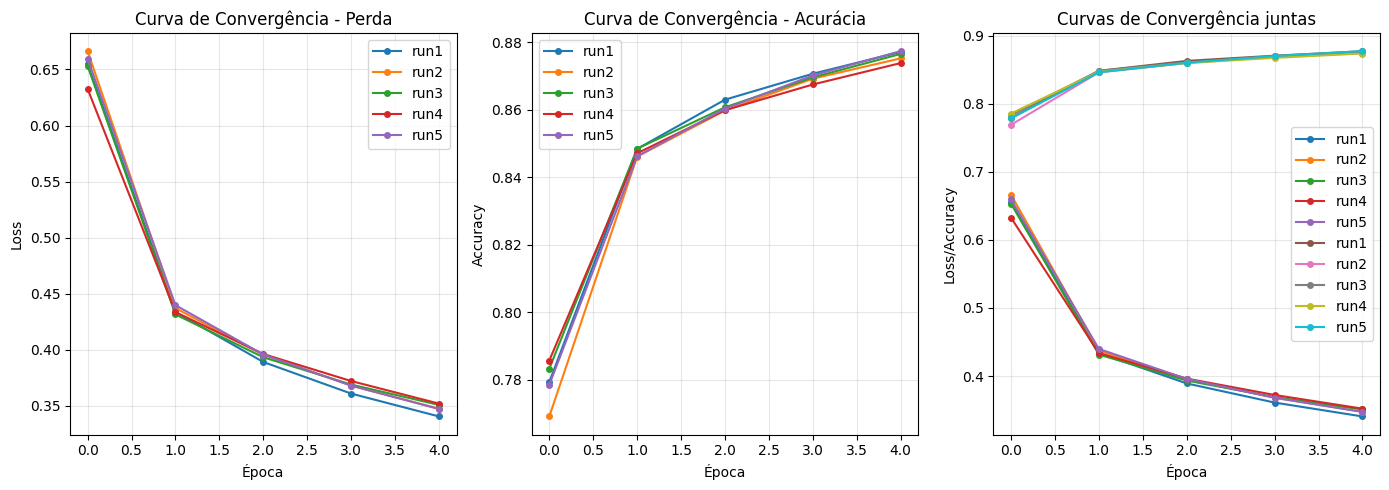


========== ESTABILIDADE ==========
Loss - média: 0.3477
Loss - desvio padrão: 0.0040
accuracy  - média: 0.8760
accuracy  - desvio padrão: 0.0013


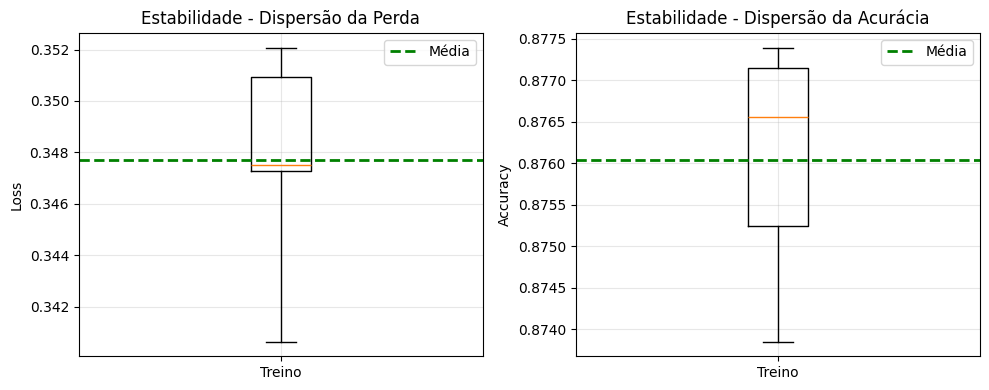


========== DESEMPENHO por seed ==========
Run 1 (seed=3824168193): Loss=0.3406, accuracy=0.8771
Run 2 (seed=3822549125): Loss=0.3475, accuracy=0.8752
Run 3 (seed=3820913677): Loss=0.3509, accuracy=0.8766
Run 4 (seed=3819296689): Loss=0.3521, accuracy=0.8739
Run 5 (seed=3817661433): Loss=0.3473, accuracy=0.8774


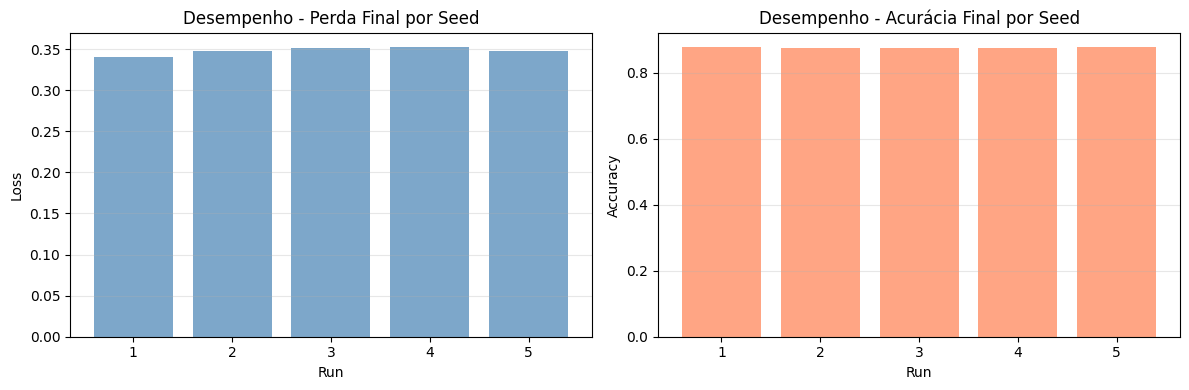


Seeds usadas: [3824168193, 3822549125, 3820913677, 3819296689, 3817661433]


In [7]:
# ========== CURVAS DE CONVERGÊNCIA ==========
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

print(f"estrutura das histories: {histories[-1].history}")
print("é possível adicionar mais informações no dicionário history, como f1, recall, precision, etc.")

#perda
for i, h in enumerate(histories, start=1):
    axes[0].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
axes[0].set_title('Curva de Convergência - Perda')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#acurácia
for i, h in enumerate(histories, start=1):
    axes[1].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[1].set_title('Curva de Convergência - Acurácia')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

#as duas(análise de over/underfitting)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
for i, h in enumerate(histories, start=1):
    axes[2].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[2].set_title('Curvas de Convergência juntas')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Loss/Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
#loss continua alta, accuracy continua baixa -> underfitting
#loss continua caindo mesmo com accuracy estagnada -> overfitting
# ========== ESTABILIDADE ==========
train_losses = [m['final_train_loss'] for m in final_metrics]
train_accuracies = [m['final_train_acc'] for m in final_metrics]

print("\n========== ESTABILIDADE ==========")
print(f"Loss - média: {np.mean(train_losses):.4f}")
print(f"Loss - desvio padrão: {np.std(train_losses):.4f}")
print(f"accuracy  - média: {np.mean(train_accuracies):.4f}")
print(f"accuracy  - desvio padrão: {np.std(train_accuracies):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#5 seeds divididas entre bigode superior(máximo), limite superior da caixa, linha laranja (mediana), limite inferior da caixa, bigode inferior(mínimo)
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title('Estabilidade - Dispersão da Perda')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['Treino'])
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title('Estabilidade - Dispersão da Acurácia')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['Treino'])
#axes[1].scatter([1]*len(train_accuracies), train_accuracies, color='red', zorder=2)
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DESEMPENHO ==========
print("\n========== DESEMPENHO por seed ==========")
for m in final_metrics:
    print(f"Run {m['run']} (seed={m['seed']}): Loss={m['final_train_loss']:.4f}, accuracy={m['final_train_acc']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(1, 6)

axes[0].bar(x, train_losses, alpha=0.7, color='steelblue')
axes[0].set_title('Desempenho - Perda Final por Seed')
axes[0].set_xlabel('Run')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, train_accuracies, alpha=0.7, color='coral')
axes[1].set_title('Desempenho - Acurácia Final por Seed')
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSeeds usadas:", seeds)

### escolha de função de ativação

In [11]:
activation_function_hidden_layer_options = ['relu', 'sigmoid', 'tanh']

### treinamento

In [13]:
# ========== TESTE DE FUNÇÕES DE ATIVAÇÃO COM CHECKPOINT ==========
seeds_q1_activation = spaced_seeds(20, base, PRIME_STEP)

# ========== DEFINIR CAMINHO DO CHECKPOINT ==========
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_file_q1_activation = checkpoint_dir / 'results_q1_activation_checkpoint.pkl'

print(f"Checkpoints serão salvos em: {checkpoint_file_q1_activation.absolute()}")

# ========== CARREGAR CHECKPOINT SE EXISTIR ==========
results_q1_activation, _, start_combo = load_checkpoint(checkpoint_file_q1_activation, 'q1_activation')

total_activations = len(activation_function_hidden_layer_options)
current_activation = 0

# ========== TREINAMENTO COM CHECKPOINT ==========
for activation_function_hidden_layer in activation_function_hidden_layer_options:
    current_activation += 1
    
    # Se já foi processado, pula
    if current_activation <= start_combo:
        print(f"⊘ Saltando {activation_function_hidden_layer} (já processada)")
        continue
    
    run_losses = []
    run_accuracies = []
    run_times = []

    print(f"\n{'='*60}")
    print(f"Testando função de ativação: {activation_function_hidden_layer}")
    print(f"{'='*60}")

    for seed_idx, s in enumerate(seeds_q1_activation, start=1):
        keras.utils.set_random_seed(s)
        model = build_model(activation_hidden=activation_function_hidden_layer)
        
        # Early stopping para acelerar
        early_stop = EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=0
        )
        
        # Medir tempo
        start_time = time.time()
        h = model.fit(x_train, y_train, epochs=40, verbose=0, callbacks=[early_stop])
        training_time = time.time() - start_time
        
        run_losses.append(h.history['loss'][-1])
        run_accuracies.append(h.history['accuracy'][-1])
        run_times.append(training_time)
        
        # Limpar memória
        del model
        keras.backend.clear_session()
        
        # Feedback a cada 5 seeds
        if seed_idx % 5 == 0:
            print(f"  Progresso: {seed_idx}/20 seeds processadas...")

    results_q1_activation.append({
        'activation_function_hidden_layer': activation_function_hidden_layer,
        'loss_mean': float(np.mean(run_losses)),
        'loss_std': float(np.std(run_losses)),
        'accuracy_mean': float(np.mean(run_accuracies)),
        'accuracy_std': float(np.std(run_accuracies)),
        'time_mean': float(np.mean(run_times)),
        'time_std': float(np.std(run_times))
    })
    
    # ========== SALVAR CHECKPOINT ==========
    save_checkpoint(checkpoint_file_q1_activation, results_q1_activation, [], current_activation, start_combo, total_activations, q_name='q1_activation', checkpoint_interval=1)
    
    print(f"✓ {activation_function_hidden_layer:12s} | Loss: {np.mean(run_losses):.4f}±{np.std(run_losses):.4f} | Acc: {np.mean(run_accuracies):.4f}±{np.std(run_accuracies):.4f} | Tempo: {np.mean(run_times):.2f}±{np.std(run_times):.2f}s")
    gc.collect()

print(f"\n✓ Teste de funções de ativação concluído: {len(results_q1_activation)} funções testadas")
print(f"✓ Checkpoint final salvo em '{checkpoint_file_q1_activation.absolute()}'")

Checkpoints serão salvos em: c:\Users\User\Desktop\computação\S4\IC\trabalho 2 IC fashion MNIST\checkpoints\results_q1_activation_checkpoint.pkl
criando arquivo de checkpoint:  checkpoints\results_q1_activation_checkpoint.pkl

Testando função de ativação: relu


KeyboardInterrupt: 

### ordenação

In [13]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q1 = sorted(
    results_q1,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Funções de ativação(melhor pra pior):")
for i,sorted_result in enumerate(sorted_results_q1[:3]):
    print(
        f"{i+1}. activation_function_hidden_layer={sorted_result['activation_function_hidden_layer']}"
        f" - Loss(média/desvio): {sorted_result['loss_mean']:.4f}/{sorted_result['loss_std']:.4f}, "
        f"Accuracy(média/desvio): {sorted_result['accuracy_mean']:.4f}/{sorted_result['accuracy_std']:.4f}"
    )

Funções de ativação(melhor pra pior):
1. activation_function_hidden_layer=sigmoid - Loss(média/desvio): 0.1402/0.0023, Accuracy(média/desvio): 0.9521/0.0010
2. activation_function_hidden_layer=tanh - Loss(média/desvio): 0.1388/0.0038, Accuracy(média/desvio): 0.9499/0.0018
3. activation_function_hidden_layer=relu - Loss(média/desvio): 0.1415/0.0041, Accuracy(média/desvio): 0.9473/0.0016


# Questão 02: hiperparâmetros

### parâmetros ajustados

In [14]:
#TODO: mais opcões de hiperparâmetros para teste exaustivo final
# Dividir em múltiplas execuções para evitar timeout de 12 horas
# Execute uma variável por vez ou em pequenos lotes

num_epochs_grid = [5, 10, 20, 30, 40]
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes = [32, 64, 128, 256]
momentums_beta1 = [0.5, 0.7, 0.9, 0.99]

print(f"Total de combinações a testar: {len(num_epochs_grid) * len(learning_rates) * len(batch_sizes) * len(momentums_beta1)}")
print(f"Tempo estimado: ~{len(num_epochs_grid) * len(learning_rates) * len(batch_sizes) * len(momentums_beta1) * 20 / 3600:.1f} horas (com 20 seeds)")


Total de combinações a testar: 320
Tempo estimado: ~1.8 horas (com 20 seeds)


### treinamento

In [15]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time
import gc
import pickle
from pathlib import Path

seeds_q2 = spaced_seeds(20, base, PRIME_STEP)

# ========== DEFINIR CAMINHO DO CHECKPOINT ==========
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_file = checkpoint_dir / 'results_q2_checkpoint.pkl'

print(f"Checkpoints serão salvos em: {checkpoint_file.absolute()}")

# ========== CARREGAR CHECKPOINT SE EXISTIR ==========
results_q2, histories_q2, start_combo = load_checkpoint(checkpoint_file, 'q2')

total_combinations = len(num_epochs_grid) * len(learning_rates) * len(batch_sizes) * len(momentums_beta1)
current_combination = 0

# ========== EARLY STOPPING COM CALLBACK ==========
from tensorflow.keras.callbacks import EarlyStopping

for epochs in num_epochs_grid:
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            for beta1 in momentums_beta1:
                current_combination += 1
                
                # Pula combinações já processadas (não treina novamente)
                if current_combination <= start_combo:
                    continue
                
                run_losses = []
                run_accuracies = []
                run_times = []

                for s in seeds_q2:
                    keras.utils.set_random_seed(s)
                    model = build_model(learning_rate=learning_rate, beta1=beta1)

                    # Early stopping: interrompe se não houver melhoria por 5 épocas
                    early_stop = EarlyStopping(
                        monitor='loss',
                        patience=5,
                        restore_best_weights=True,
                        verbose=0
                    )

                    # Mede tempo de treinamento
                    start_time = time.time()
                    h = model.fit(
                        x_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        callbacks=[early_stop],
                        verbose=0
                    )
                    training_time = time.time() - start_time

                    histories_q2.append(h)
                    run_losses.append(h.history['loss'][-1])
                    run_accuracies.append(h.history['accuracy'][-1])
                    run_times.append(training_time)
                    
                    # Limpa modelo para liberar memória
                    del model
                    keras.backend.clear_session()

                results_q2.append({
                    'epochs': epochs,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'beta1': beta1,
                    'loss_mean': float(np.mean(run_losses)),
                    'loss_std': float(np.std(run_losses)),
                    'accuracy_mean': float(np.mean(run_accuracies)),
                    'accuracy_std': float(np.std(run_accuracies)),
                    'time_mean': float(np.mean(run_times)),
                    'time_std': float(np.std(run_times))
                })
                
                # ========== SALVAR CHECKPOINT ==========
                save_checkpoint(checkpoint_file, results_q2, histories_q2, current_combination, start_combo, total_combinations, checkpoint_interval=10)

print(f"\n✓ Treinamento Q2 concluído: {len(results_q2)} combinações testadas")
print(f"✓ Checkpoint final salvo em '{checkpoint_file.absolute()}'")

"""Remover arquivo de checkpoint após conclusão bem-sucedida
if checkpoint_file_q2.exists():
    checkpoint_file_q2.unlink()
    print("✓ Arquivo de checkpoint removido (conclusão bem-sucedida)")"""

Checkpoints serão salvos em: c:\Users\User\Desktop\computação\S4\IC\trabalho 2 IC fashion MNIST\checkpoints\results_q2_checkpoint.pkl

✓ Carregando checkpoint anterior...


KeyboardInterrupt: 

In [17]:
show_checkpoint(checkpoint_dir / 'results_q2_checkpoint_2.pkl', max_items=5)

✓ Carregando checkpoint no caminho: C:\Users\User\Desktop\computação\S4\IC\trabalho 2 IC fashion MNIST\checkpoints\results_q2_checkpoint_2.pkl
✓ Checkpoint carregado
Campos: ['results_q2', 'histories_q2', 'last_combination']
Total de combinações salvas: 0
Total de históricos salvos: 0
Última combinação: 125
Nenhum resultado salvo no checkpoint.


In [18]:
#resultados e histórico finais
results_q2 = []
histories_q2 = []
with open(checkpoint_dir / 'results_q2_checkpoint.pkl', 'rb') as f:
    checkpoint = pickle.load(f)
results_q2 = checkpoint['results_q2']
histories_q2 = checkpoint['histories_q2']
print("resultados do primeiro treino coletados")
with open(checkpoint_dir / 'results_q2_checkpoint_2.pkl', 'rb') as f:
    checkpoint = pickle.load(f)
results_q2 += checkpoint['results_q2']
histories_q2 += checkpoint['histories_q2']
print("resultados do segundo treino coletados")
with open(checkpoint_dir / 'results_q2_checkpoint_3.pkl', 'rb') as f:
    checkpoint = pickle.load(f)
results_q2 += checkpoint['results_q2']
histories_q2 += checkpoint['histories_q2']

print("tamanho de results_q2: ", len(results_q2), " tamanho de histories_q2: ", len(histories_q2))

resultados do primeiro treino coletados
resultados do segundo treino coletados
tamanho de results_q2:  317  tamanho de histories_q2:  6340


### ordenação

In [19]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
sorted_results_q2 = sorted(
    results_q2,
    key=lambda sorted_result: (-(sorted_result['accuracy_mean']), sorted_result['loss_mean'], sorted_result['loss_std'] + sorted_result['accuracy_std'])
)

print("Top 10 melhores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[:10]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

print("\n\nTop 10 piores combinações (melhor pro pior):")
for i,sorted_result in enumerate(sorted_results_q2[-10:-1]):
    print(
        f"{i+1}. epochs={sorted_result['epochs']}, learning_rate={sorted_result['learning_rate']},"
        f" batch={sorted_result['batch_size']}, beta1={sorted_result['beta1']} | "
        f"loss_mean={sorted_result['loss_mean']:.4f} (±{sorted_result['loss_std']:.4f}), "
        f"accuracy_mean={sorted_result['accuracy_mean']:.4f} (±{sorted_result['accuracy_std']:.4f})"
    )

Top 10 melhores combinações (melhor pro pior):
1. epochs=40, learning_rate=0.001, batch=64, beta1=0.5 | loss_mean=0.1344 (±0.0031), accuracy_mean=0.9510 (±0.0014)
2. epochs=40, learning_rate=0.001, batch=32, beta1=0.5 | loss_mean=0.1325 (±0.0034), accuracy_mean=0.9508 (±0.0013)
3. epochs=40, learning_rate=0.001, batch=64, beta1=0.7 | loss_mean=0.1360 (±0.0039), accuracy_mean=0.9505 (±0.0018)
4. epochs=40, learning_rate=0.001, batch=32, beta1=0.7 | loss_mean=0.1350 (±0.0034), accuracy_mean=0.9499 (±0.0015)
5. epochs=40, learning_rate=0.001, batch=32, beta1=0.9 | loss_mean=0.1418 (±0.0024), accuracy_mean=0.9473 (±0.0010)
6. epochs=40, learning_rate=0.001, batch=128, beta1=0.5 | loss_mean=0.1503 (±0.0041), accuracy_mean=0.9461 (±0.0017)
7. epochs=40, learning_rate=0.001, batch=64, beta1=0.9 | loss_mean=0.1460 (±0.0048), accuracy_mean=0.9461 (±0.0018)
8. epochs=40, learning_rate=0.001, batch=128, beta1=0.7 | loss_mean=0.1506 (±0.0024), accuracy_mean=0.9459 (±0.0011)
9. epochs=30, learning_

### comparações

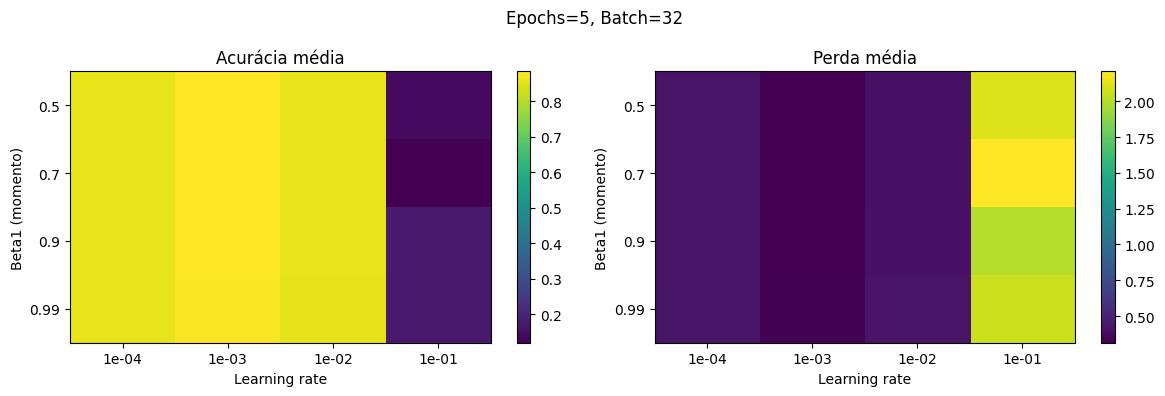

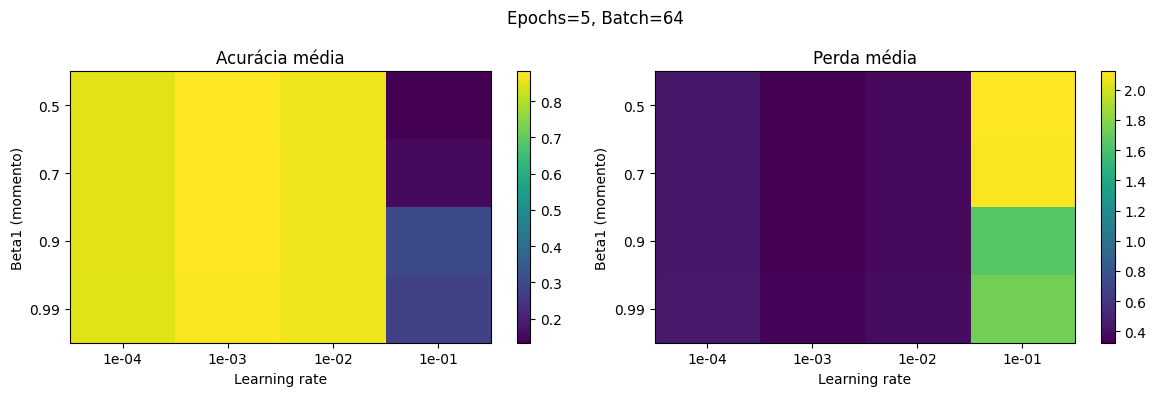

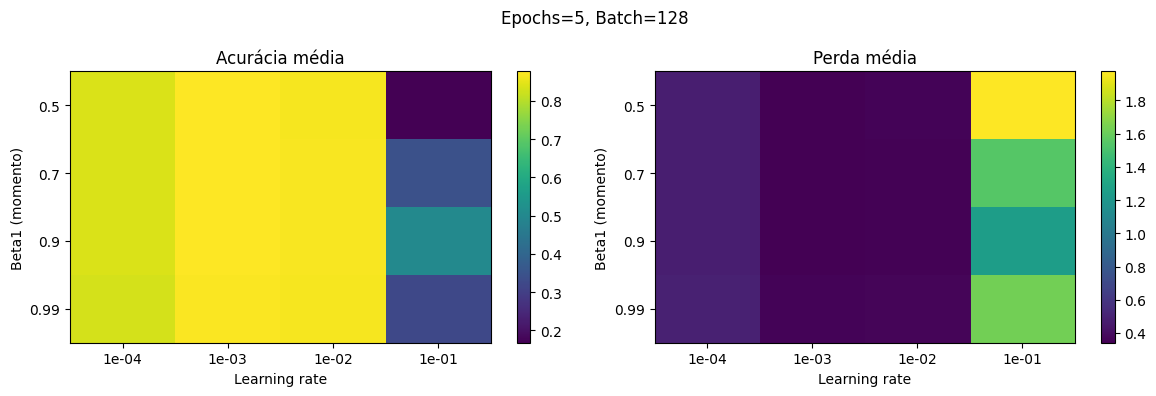

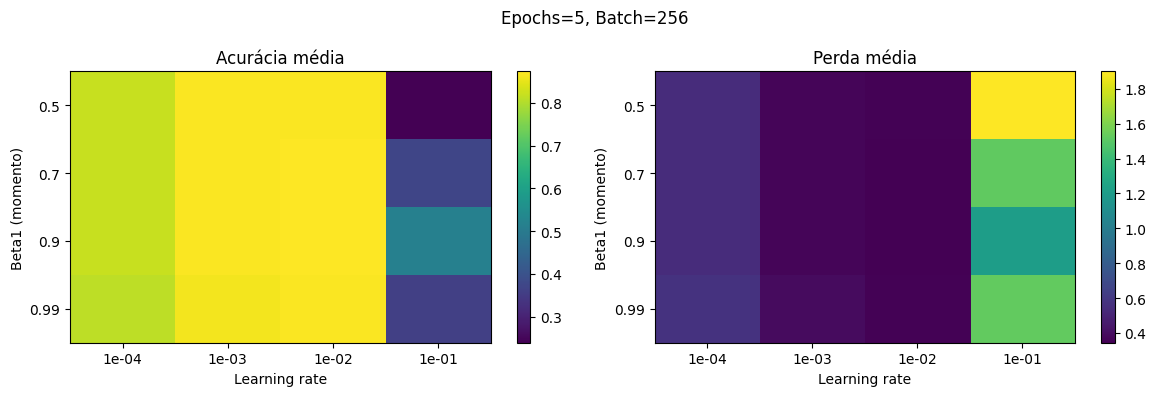

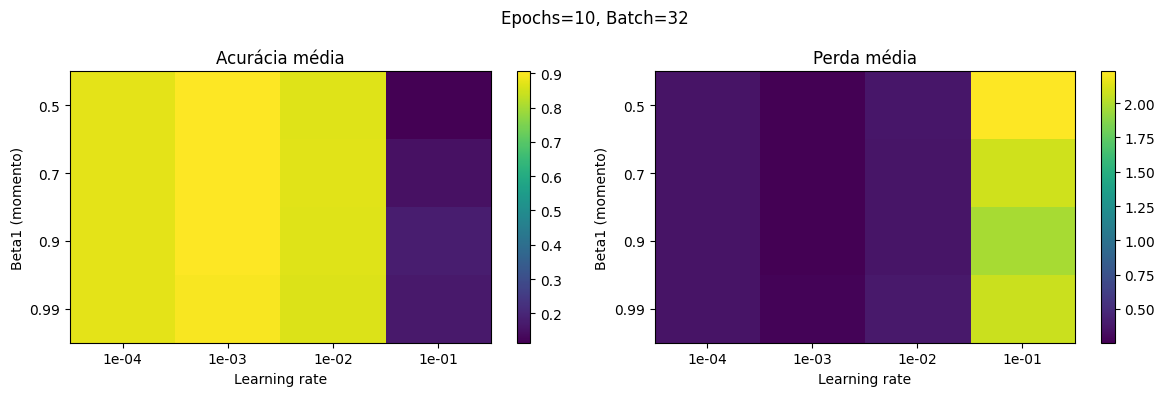

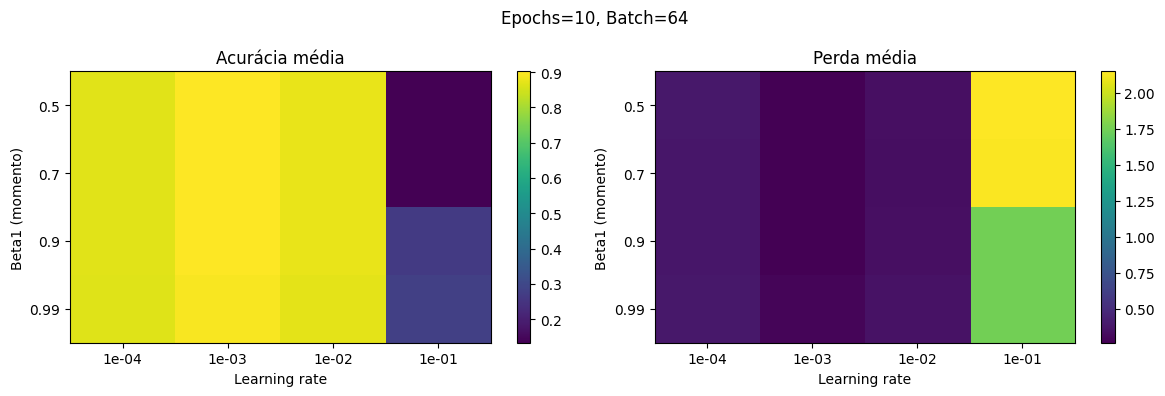

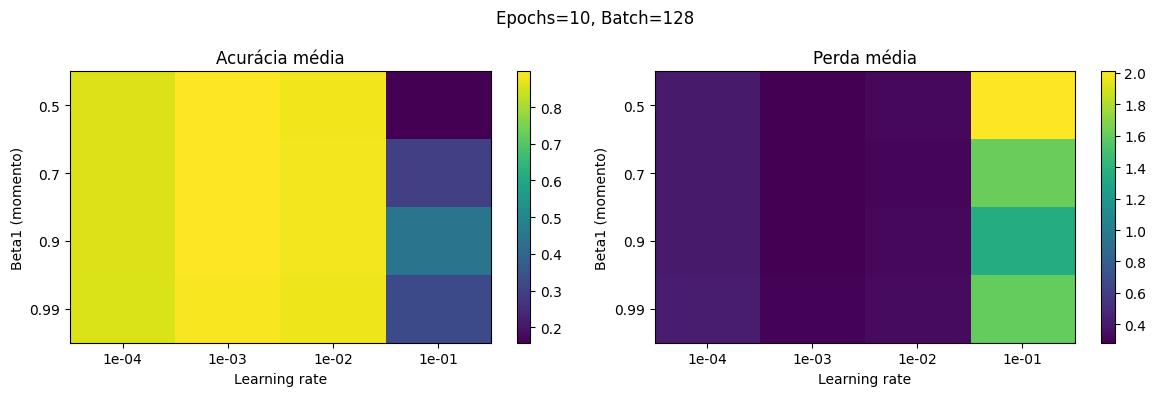

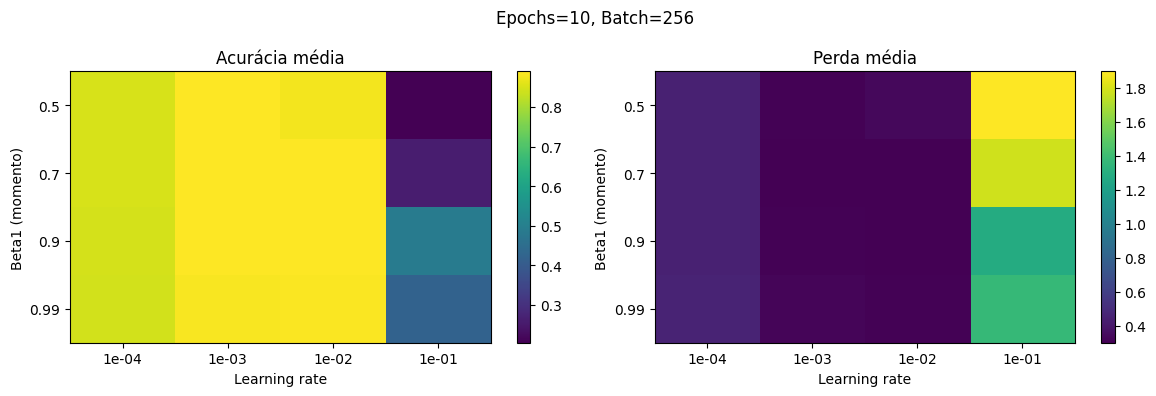

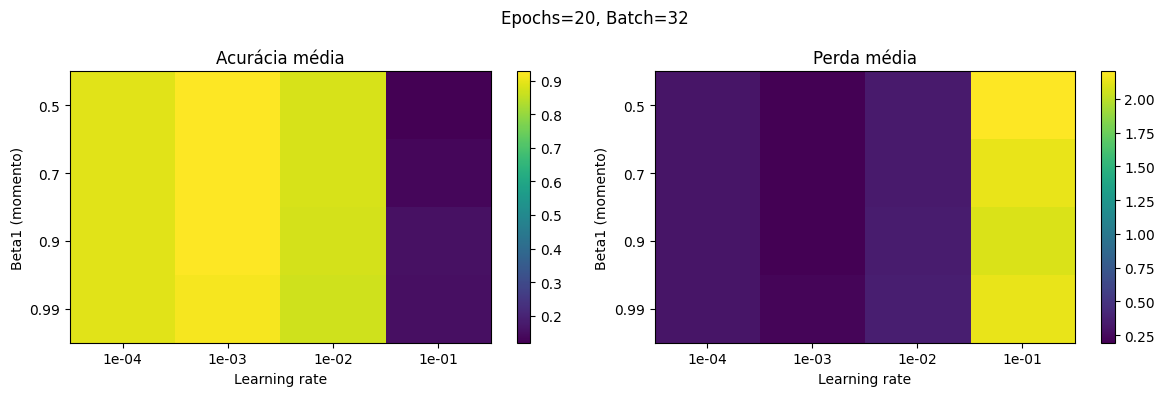

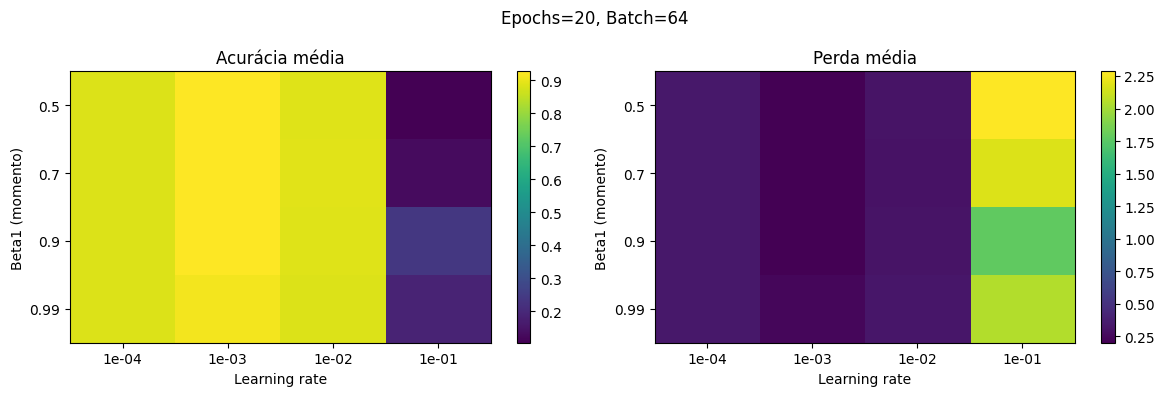

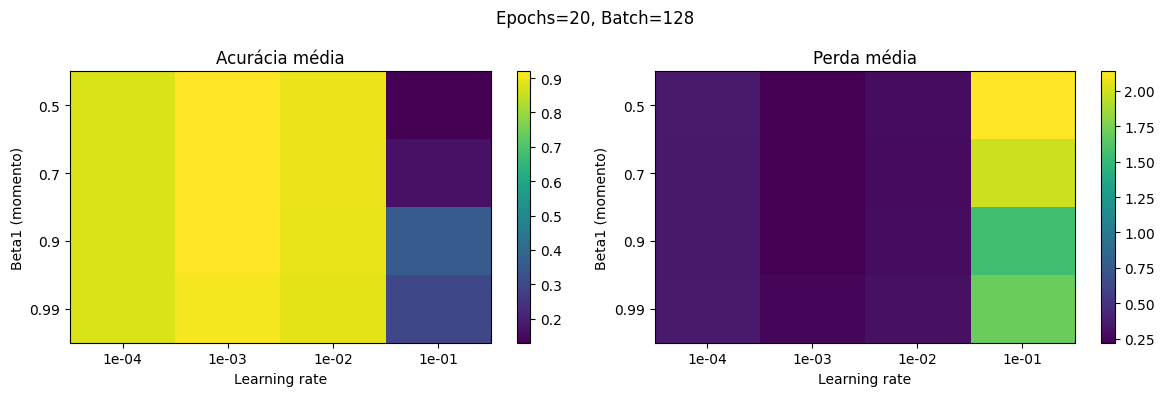

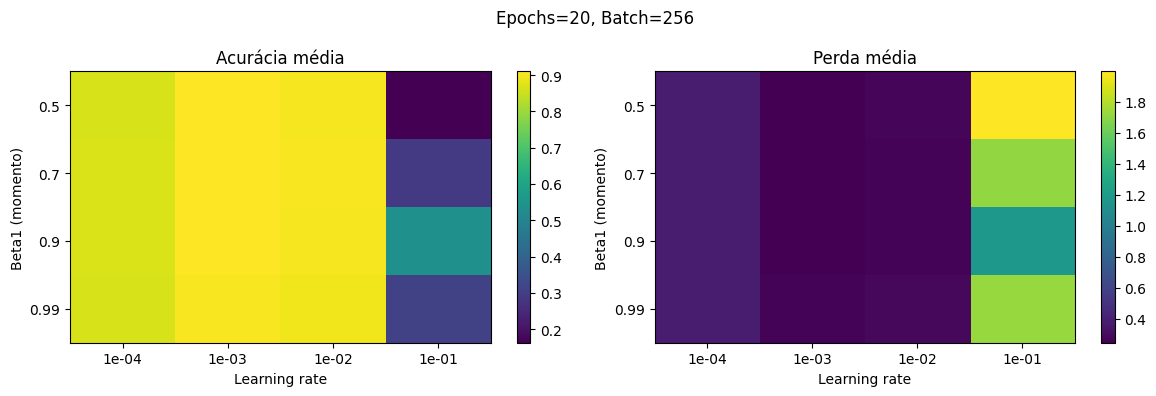

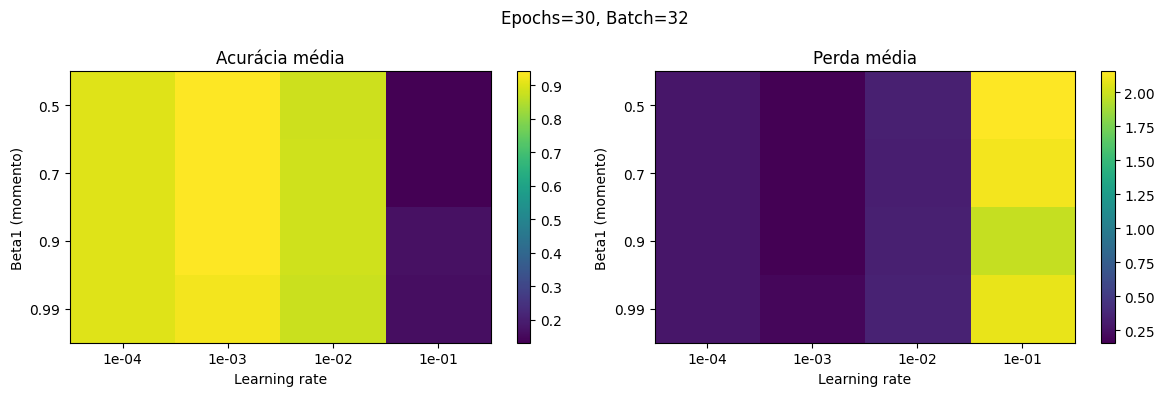

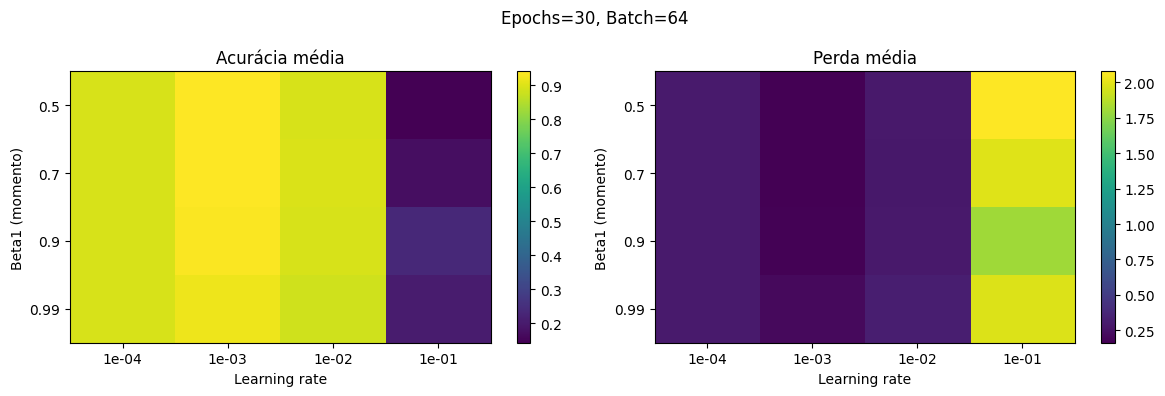

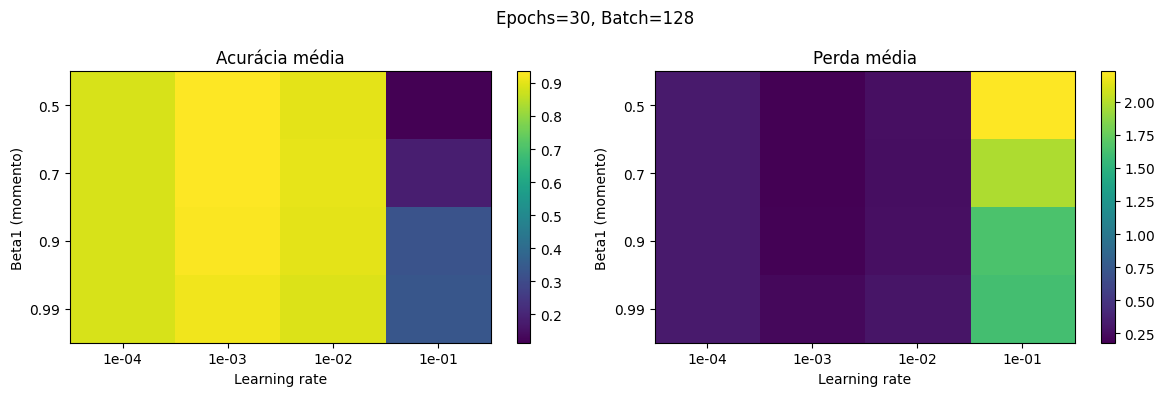

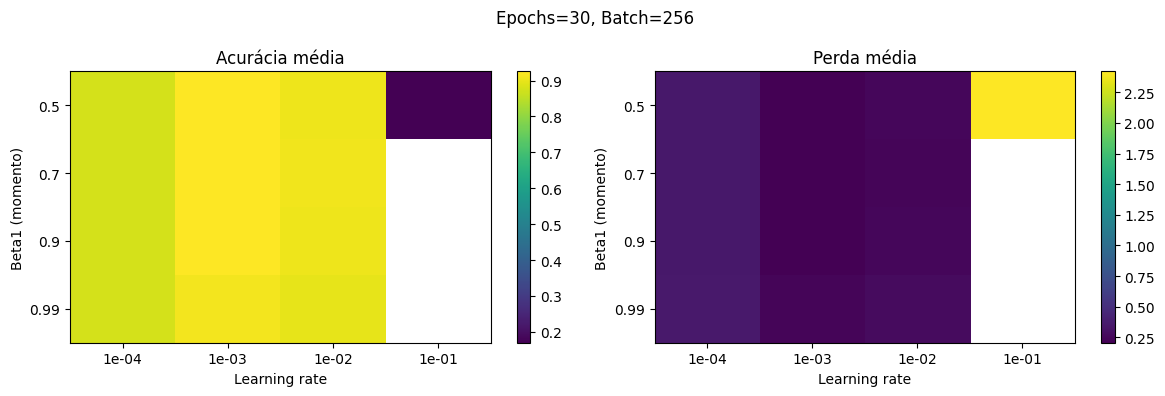

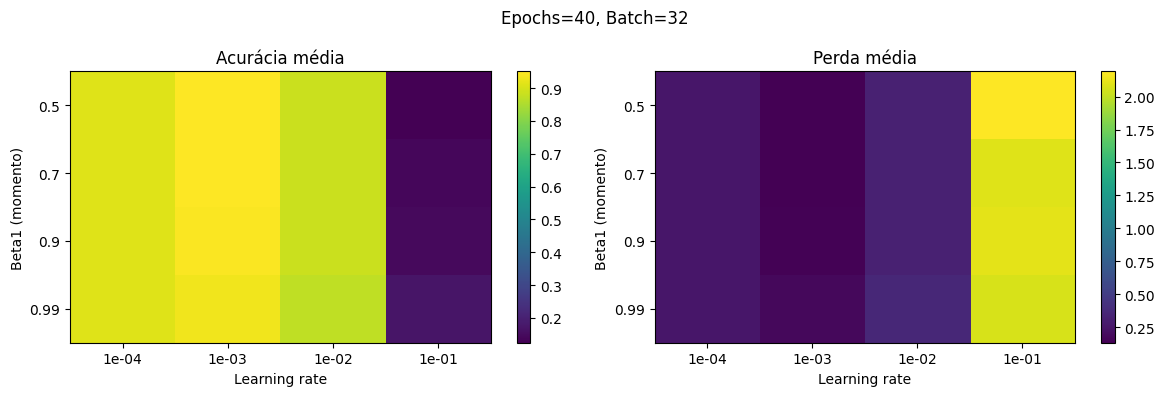

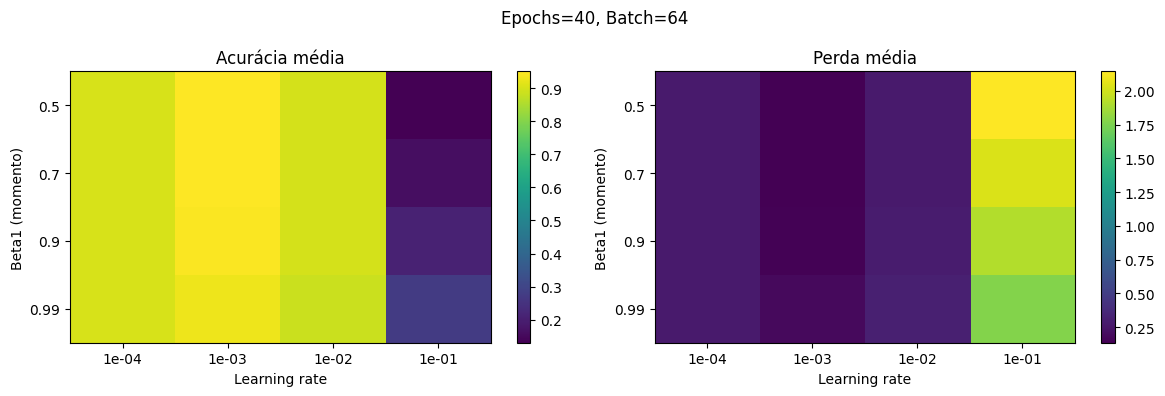

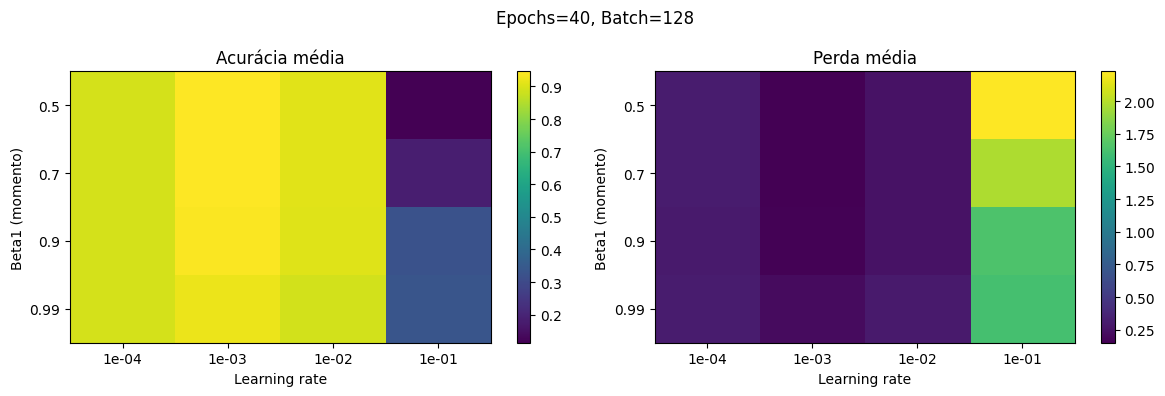

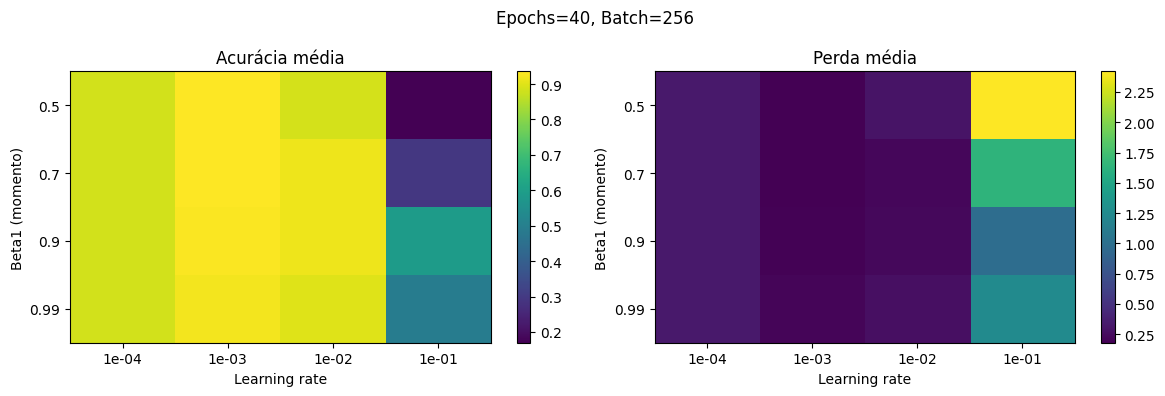

In [20]:
# Loop sobre epochs e batch_size: para cada combinação, gera mapas de calor 2D (beta1 x learning_rate)
# usando as métricas agregadas em `results`.

# Conjuntos ordenados de parâmetros disponíveis em `results`
unique_epochs = sorted(list({r['epochs'] for r in results_q2}))
unique_batch_sizes = sorted(list({r['batch_size'] for r in results_q2}))
unique_beta1s = sorted(list({r['beta1'] for r in results_q2}))
unique_learning_rates = sorted(list({r['learning_rate'] for r in results_q2}))

# Para cada (epochs, batch_size), monta matrizes 2D [beta1 x lr] de acurácia e perda
for epochs in unique_epochs:
    for batch_size in unique_batch_sizes:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['epochs'] == epochs and r['batch_size'] == batch_size]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        b1_index = {b1: i for i, b1 in enumerate(unique_beta1s)}
        lr_index = {lr: j for j, lr in enumerate(unique_learning_rates)}

        accuracy_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)
        loss_matrix = np.full((len(unique_beta1s), len(unique_learning_rates)), np.nan)

        for r in subset:
            i = b1_index[r['beta1']]
            j = lr_index[r['learning_rate']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"Epochs={epochs}, Batch={batch_size}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='viridis', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_learning_rates)))
        axes[0].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[0].set_yticks(range(len(unique_beta1s)))
        axes[0].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[0].set_xlabel('Learning rate')
        axes[0].set_ylabel('Beta1 (momento)')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='viridis', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_learning_rates)))
        axes[1].set_xticklabels([f"{lr:.0e}" for lr in unique_learning_rates])
        axes[1].set_yticks(range(len(unique_beta1s)))
        axes[1].set_yticklabels([str(b1) for b1 in unique_beta1s])
        axes[1].set_xlabel('Learning rate')
        axes[1].set_ylabel('Beta1 (momento)')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()
#esperado: loss com cores invertidas de accuracy -> equilibrados

### visualização alternativa

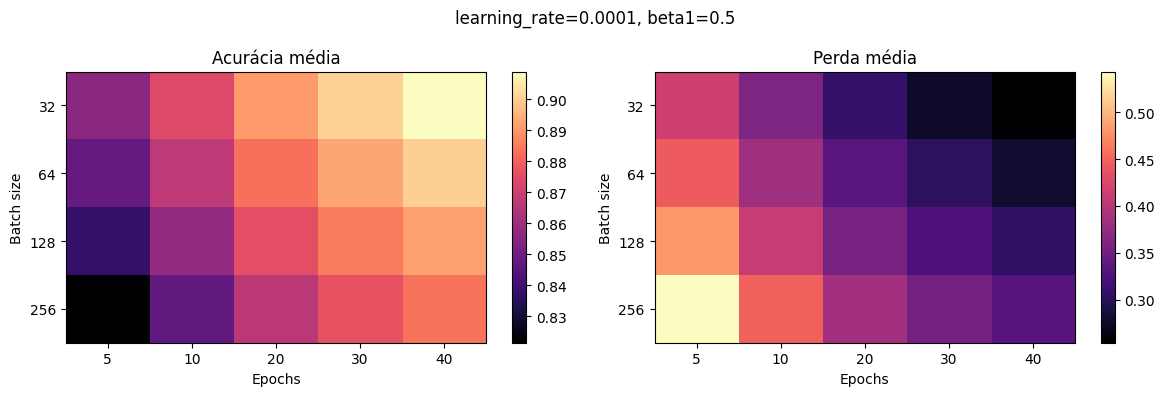

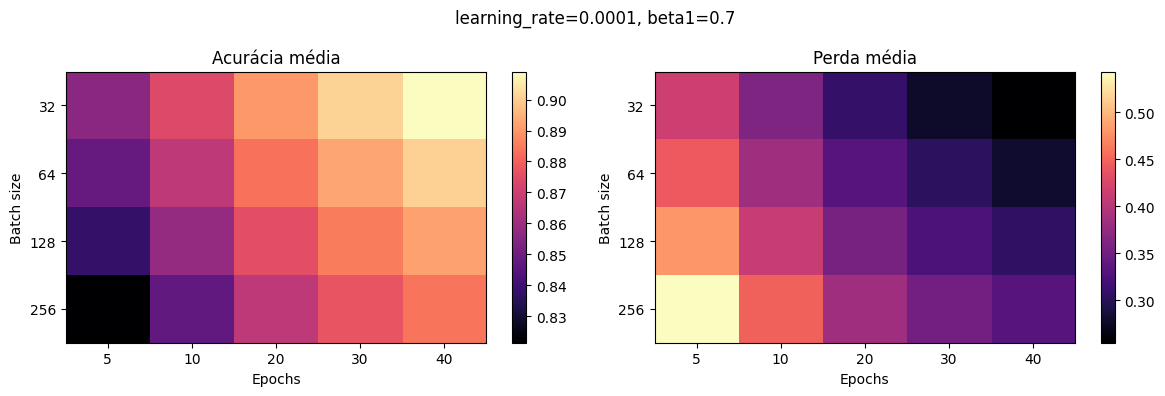

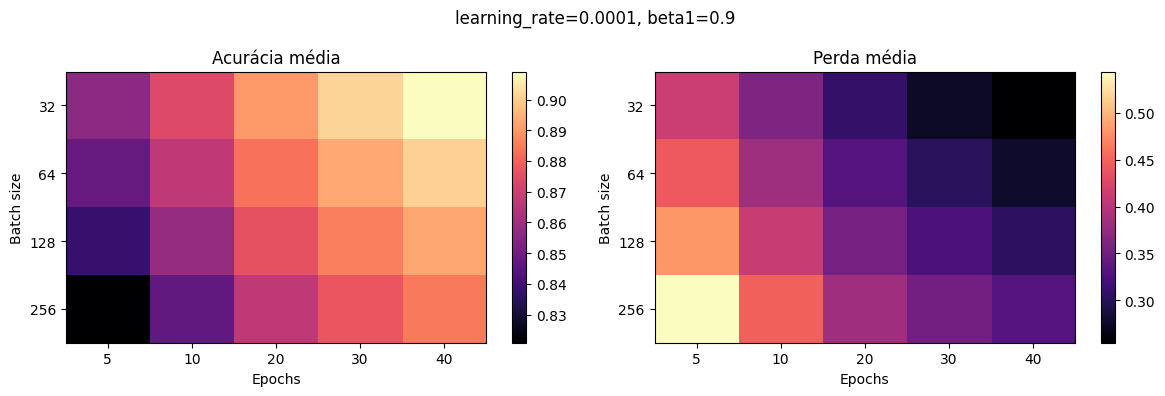

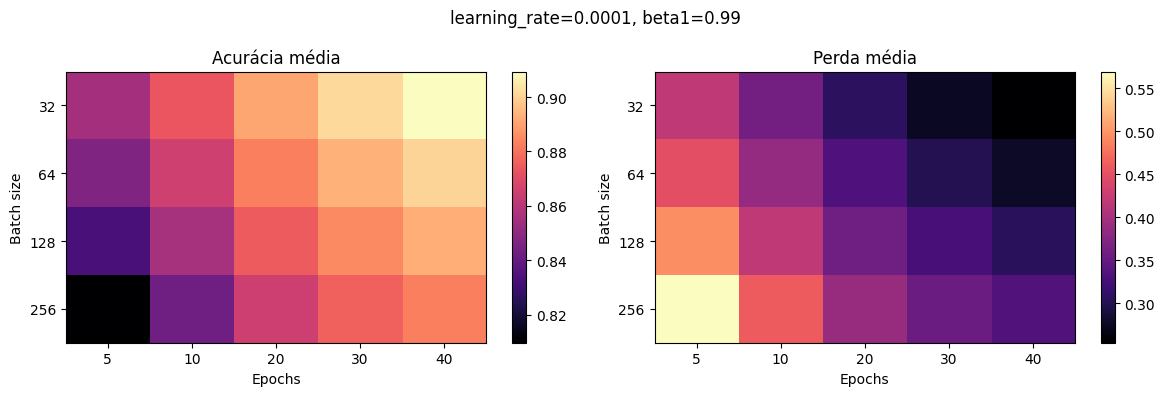

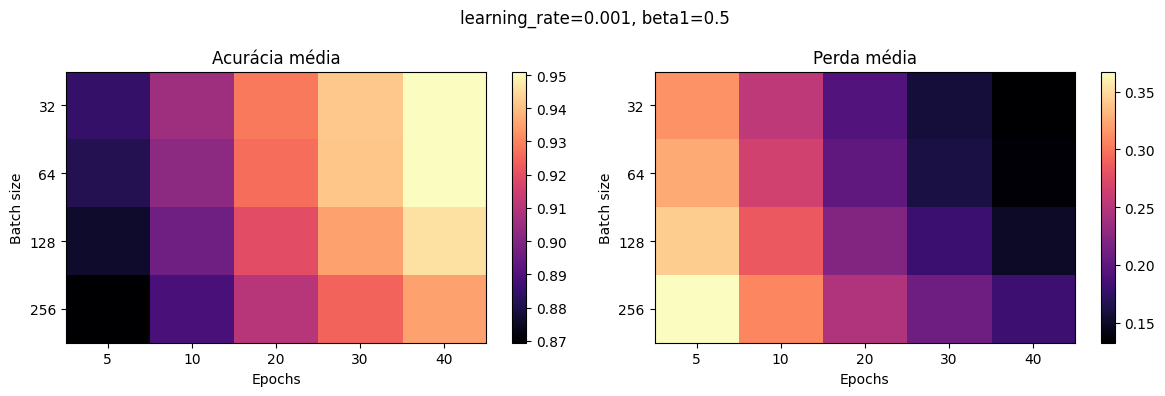

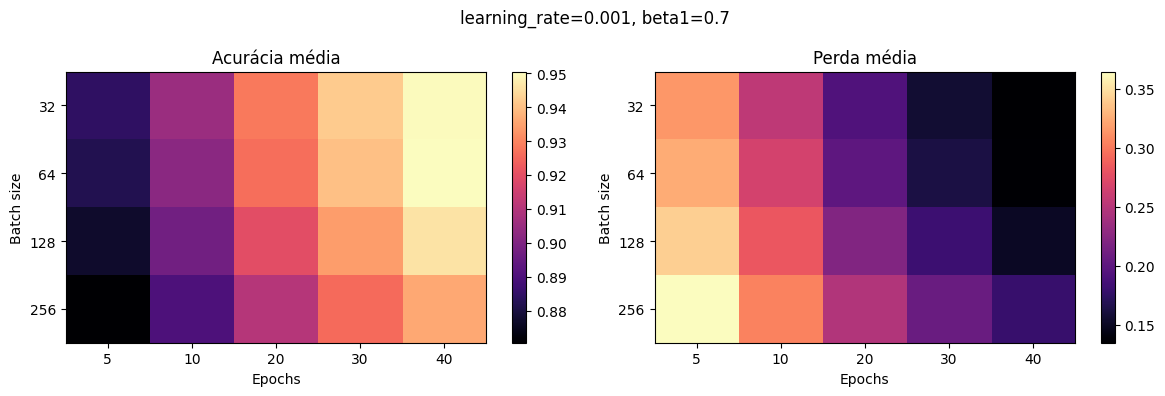

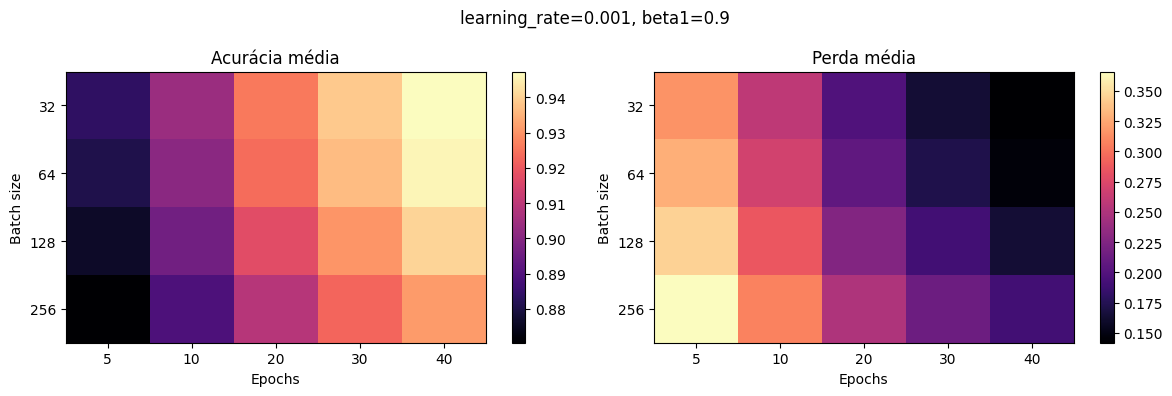

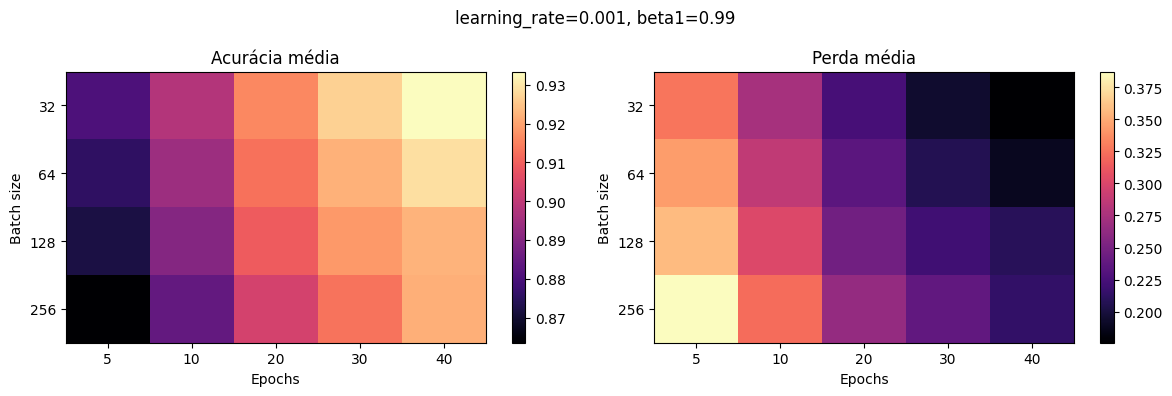

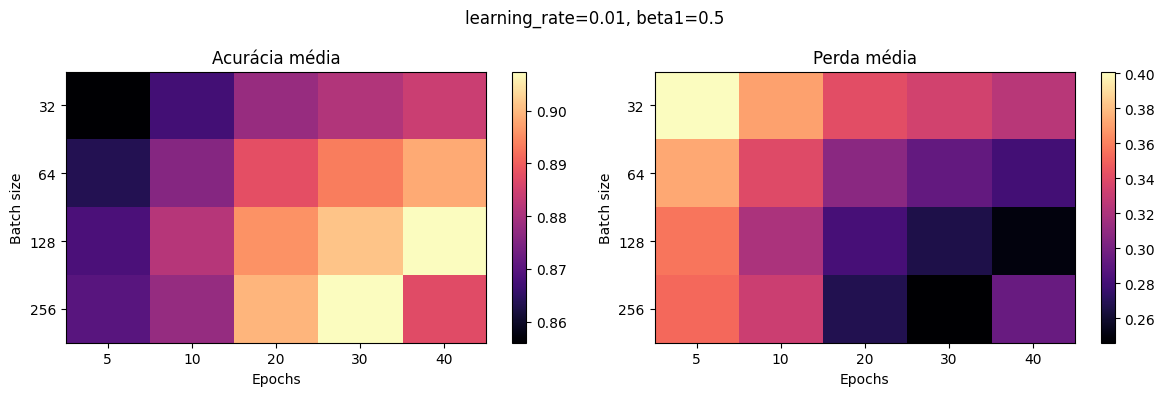

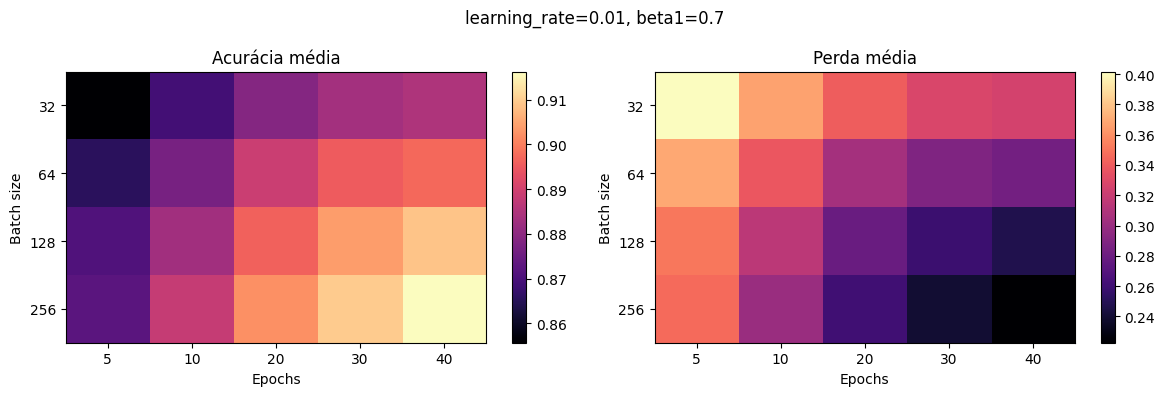

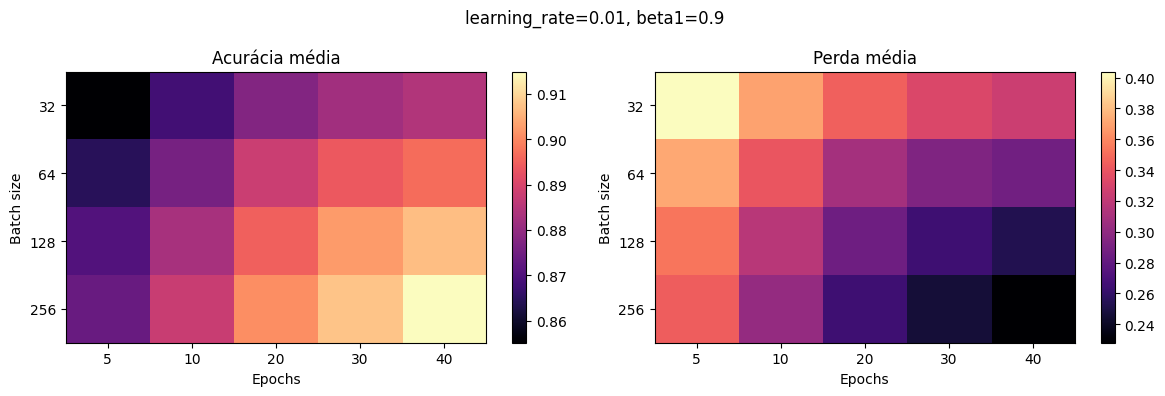

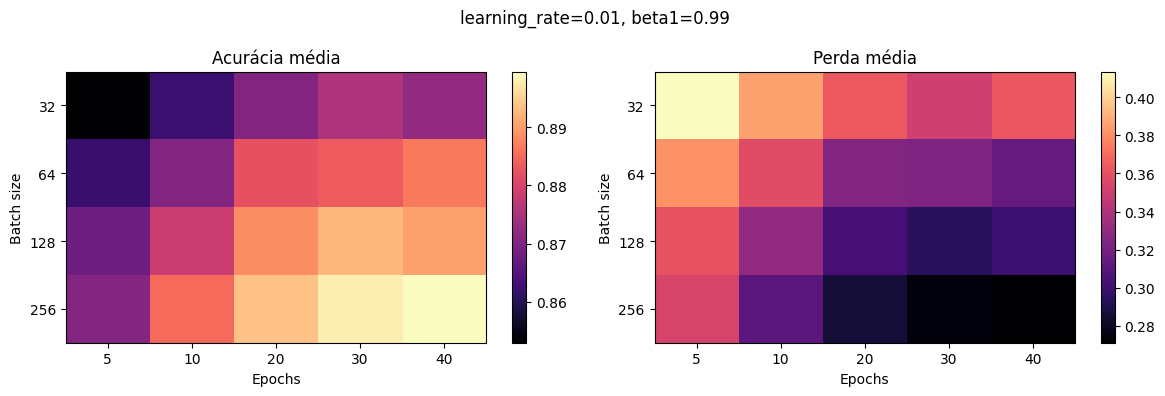

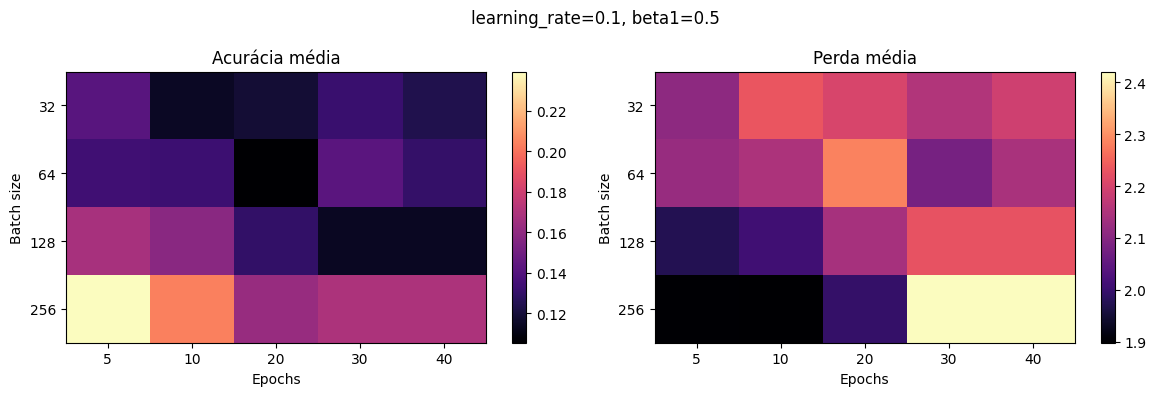

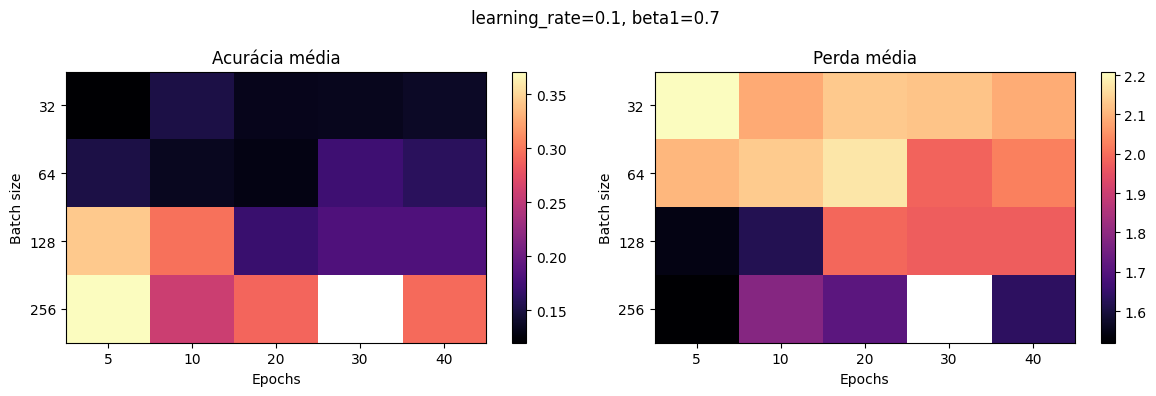

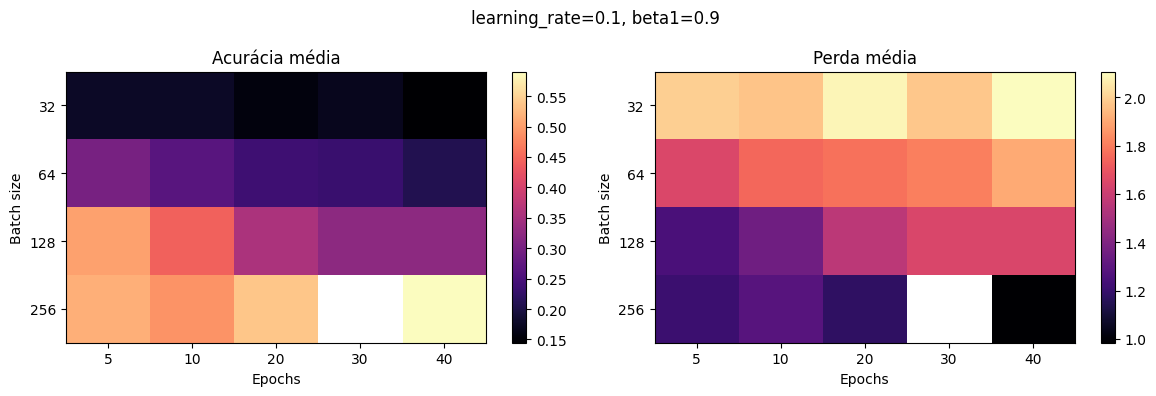

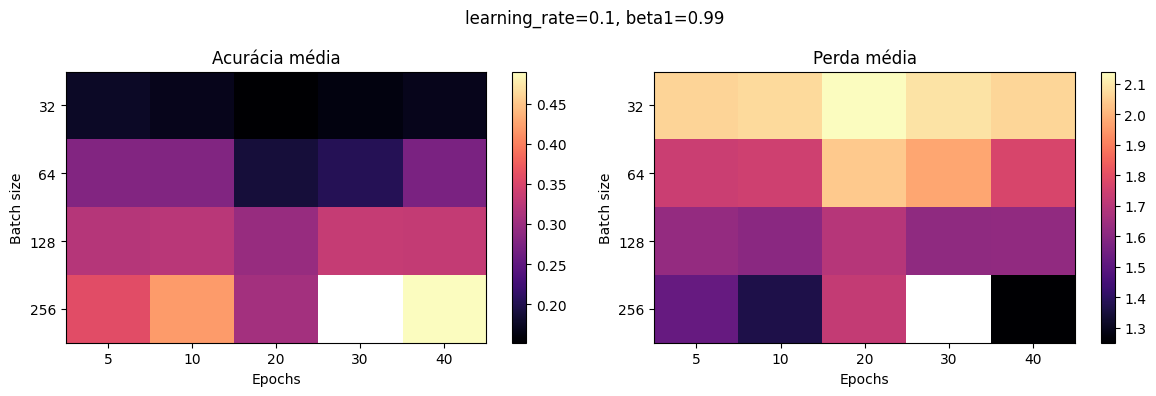

In [21]:
# Para cada (lr, beta1), monta matrizes 2D [epoch x batch_size] de acurácia e perda
for learning_rate in unique_learning_rates:
    for beta1 in unique_beta1s:
        # Filtra resultados referentes à combinação fixa (epochs, batch_size)
        subset = [r for r in results_q2 if r['learning_rate'] == learning_rate and r['beta1'] == beta1]
        if not subset:
            continue
        # Índices para mapeamento beta1 x lr
        ba_index = {ba: i for i, ba in enumerate(unique_batch_sizes)}
        ep_index = {ep: j for j, ep in enumerate(unique_epochs)}

        accuracy_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)
        loss_matrix = np.full((len(unique_batch_sizes), len(unique_epochs)), np.nan)

        for r in subset:
            i = ba_index[r['batch_size']]
            j = ep_index[r['epochs']]
            accuracy_matrix[i, j] = r['accuracy_mean']
            loss_matrix[i, j] = r['loss_mean']

        # Visualização dos mapas de calor
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"learning_rate={learning_rate}, beta1={beta1}")

        im0 = axes[0].imshow(accuracy_matrix, cmap='magma', aspect='auto')
        axes[0].set_title('Acurácia média')
        axes[0].set_xticks(range(len(unique_epochs)))
        axes[0].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[0].set_yticks(range(len(unique_batch_sizes)))
        axes[0].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Batch size')
        plt.colorbar(im0, ax=axes[0])

        im1 = axes[1].imshow(loss_matrix, cmap='magma', aspect='auto')
        axes[1].set_title('Perda média')
        axes[1].set_xticks(range(len(unique_epochs)))
        axes[1].set_xticklabels([str(ep) for ep in unique_epochs])
        axes[1].set_yticks(range(len(unique_batch_sizes)))
        axes[1].set_yticklabels([str(b) for b in unique_batch_sizes])
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Batch size')
        plt.colorbar(im1, ax=axes[1])

        plt.tight_layout()
        plt.show()

### métricas

Total de combinações testadas: 317
========== CURVAS DE CONVERGÊNCIA ==========


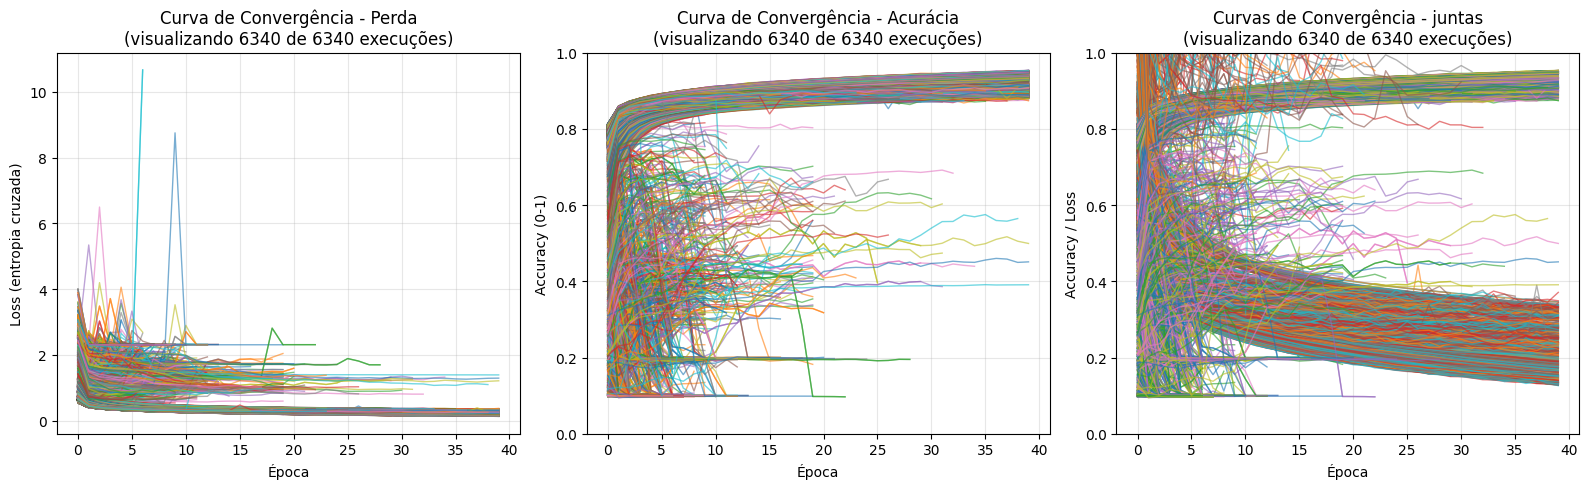


========== ESTABILIDADE (n=6340) ==========


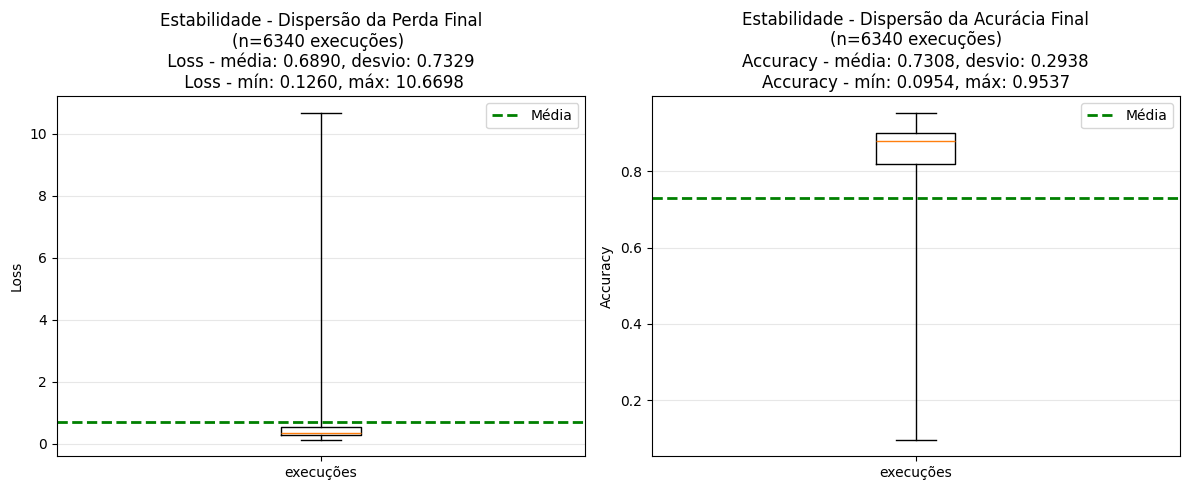


========== TEMPO DE TREINAMENTO ==========
Tempo médio geral: 24.26s (±29.71s)
Tempo mínimo: 2.28s
Tempo máximo: 270.15s

Tempo médio por número de épocas:
  5 épocas: 11.61s (±8.41s)
  10 épocas: 11.17s (±5.71s)
  20 épocas: 13.85s (±8.00s)
  30 épocas: 38.17s (±40.70s)
  40 épocas: 47.16s (±38.43s)


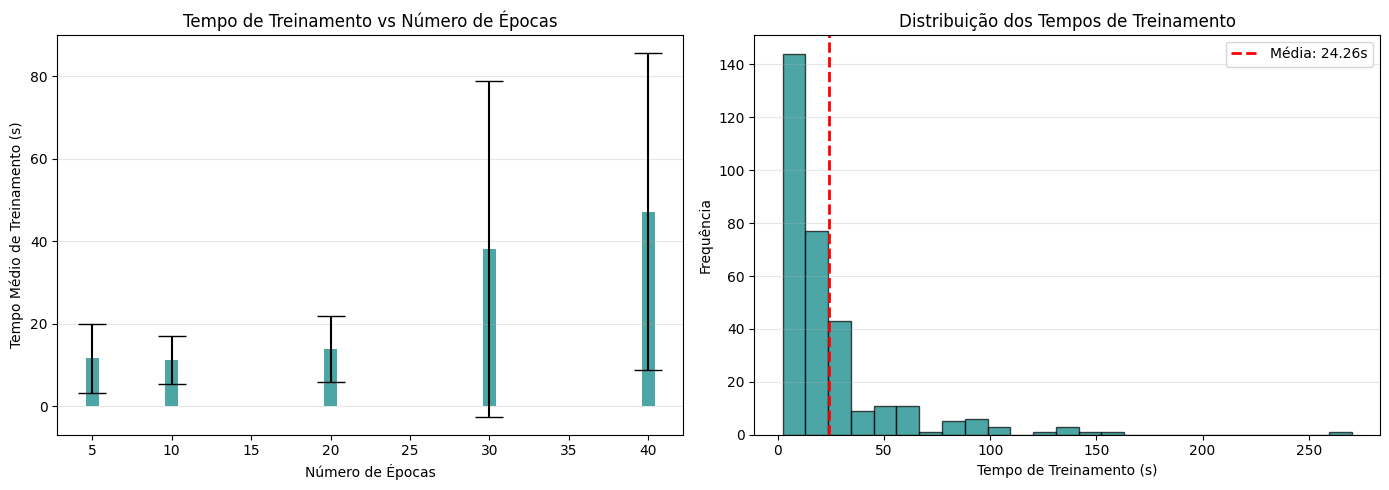


========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========
1. Tempo: 2.28s | epochs=5, lr=0.1, batch=256, beta1=0.7
   Loss: 1.5197, Acc: 0.3709
2. Tempo: 2.28s | epochs=5, lr=0.1, batch=256, beta1=0.5
   Loss: 1.9003, Acc: 0.2393
3. Tempo: 2.54s | epochs=5, lr=0.1, batch=256, beta1=0.9
   Loss: 1.2098, Acc: 0.5159
4. Tempo: 2.58s | epochs=5, lr=0.1, batch=256, beta1=0.99
   Loss: 1.5238, Acc: 0.3589
5. Tempo: 3.05s | epochs=5, lr=0.1, batch=128, beta1=0.99
   Loss: 1.6240, Acc: 0.3207

========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========
1. Tempo: 138.52s | epochs=40, lr=0.0001, batch=32, beta1=0.7
   Loss: 0.2547, Acc: 0.9091
2. Tempo: 141.36s | epochs=40, lr=0.0001, batch=32, beta1=0.99
   Loss: 0.2541, Acc: 0.9094
3. Tempo: 151.10s | epochs=30, lr=0.0001, batch=64, beta1=0.99
   Loss: 0.3002, Acc: 0.8931
4. Tempo: 160.67s | epochs=40, lr=0.0001, batch=32, beta1=0.5
   Loss: 0.2544, Acc: 0.9090
5. Tempo: 270.15s | epochs=30, lr=0.1, batch=32, beta1=0.5
   Loss: 2.1545, Acc: 0.1317


In [23]:
print(f"Total de combinações testadas: {len(results_q2)}")


print("========== CURVAS DE CONVERGÊNCIA ==========")
sample_step = 1 # mostra modelos 1 a 1, ajuste para visualização menos poluída
sample_indices = list(range(0, len(histories_q2), sample_step)) #start, stop, step

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#perda
for idx in sample_indices:
    h = histories_q2[idx]
    axes[0].plot(h.history['loss'], alpha=0.6, linewidth=1)
axes[0].set_title(f'Curva de Convergência - Perda\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (entropia cruzada)')
axes[0].grid(True, alpha=0.3)

#acurácia
for idx in sample_indices:
    h = histories_q2[idx]
    axes[1].plot(h.history['accuracy'], alpha=0.6, linewidth=1)
axes[1].set_title(f'Curva de Convergência - Acurácia\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy (0-1)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

#as duas
for idx in sample_indices:
    h = histories_q2[idx]
    axes[2].plot(h.history['accuracy'], alpha=0.6, linewidth=1)
    axes[2].plot(h.history['loss'], alpha=0.6, linewidth=1)
axes[2].set_title(f'Curvas de Convergência - juntas\n(visualizando {len(sample_indices)} de {len(histories_q2)} execuções)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Accuracy / Loss')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()


train_losses = [h.history['loss'][-1] for h in histories_q2]
train_accuracies = [h.history['accuracy'][-1] for h in histories_q2]
print(f"\n========== ESTABILIDADE (n={len(train_losses)}) ==========")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot de Loss
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title(f'Estabilidade - Dispersão da Perda Final\n(n={len(train_losses)} execuções) '
                  f'\n Loss - média: {np.mean(train_losses):.4f}, desvio: {np.std(train_losses):.4f} '
                  f'\n Loss - mín: {np.min(train_losses):.4f}, máx: {np.max(train_losses):.4f}')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['execuções'])
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
#pontos individuais
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Boxplot de Accuracy
axes[1].boxplot(train_accuracies, whis=(0, 100))
axes[1].set_title(f'Estabilidade - Dispersão da Acurácia Final\n(n={len(train_accuracies)} execuções)'
                  f'\nAccuracy - média: {np.mean(train_accuracies):.4f}, desvio: {np.std(train_accuracies):.4f}'
                  f'\nAccuracy - mín: {np.min(train_accuracies):.4f}, máx: {np.max(train_accuracies):.4f}')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['execuções'])
axes[1].axhline(y=np.mean(train_accuracies), color='green', linestyle='--', linewidth=2, label='Média')
#pontos individuais
#axes[1].scatter([1]*len(train_accuracies), train_accuracies, color='red', zorder=2)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


print("\n========== TEMPO DE TREINAMENTO ==========")

all_times = [r['time_mean'] for r in results_q2]
all_time_stds = [r['time_std'] for r in results_q2]
#média e desvio do tempo de execução do mesmo modelo para todas as seeds

print(f"Tempo médio geral: {np.mean(all_times):.2f}s (±{np.std(all_times):.2f}s)")
print(f"Tempo mínimo: {np.min(all_times):.2f}s")
print(f"Tempo máximo: {np.max(all_times):.2f}s")

#tempo por quantidade total de épocas do modelo
time_by_epochs = {}
for r in results_q2:
    ep = r['epochs']
    if ep not in time_by_epochs:
        time_by_epochs[ep] = []
    time_by_epochs[ep].append(r['time_mean'])

print("\nTempo médio por número de épocas:")
for ep in sorted(time_by_epochs.keys()):
    print(f"  {ep} épocas: {np.mean(time_by_epochs[ep]):.2f}s (±{np.std(time_by_epochs[ep]):.2f}s)")

# Gráfico de tempo por épocas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_list = sorted(time_by_epochs.keys())
mean_times = [np.mean(time_by_epochs[ep]) for ep in epochs_list]
std_times = [np.std(time_by_epochs[ep]) for ep in epochs_list]

axes[0].set_title('Tempo de Treinamento vs Número de Épocas')
axes[0].bar(epochs_list, mean_times, yerr=std_times, alpha=0.7, capsize=10, color='teal')
axes[0].set_xlabel('Número de Épocas')
axes[0].set_ylabel('Tempo Médio de Treinamento (s)')
axes[0].grid(True, alpha=0.3, axis='y')


axes[1].set_title('Distribuição dos Tempos de Treinamento')
axes[1].hist(all_times, bins=25, alpha=0.7, color='teal', edgecolor='black')
axes[1].axvline(np.mean(all_times), color='red', linestyle='--', linewidth=2, label=f'Média: {np.mean(all_times):.2f}s')
axes[1].set_xlabel('Tempo de Treinamento (s)')
axes[1].set_ylabel('Frequência')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


print("\n========== TOP 5 COMBINAÇÕES MAIS RÁPIDAS ==========")
sorted_by_time = sorted(results_q2, key=lambda x: x['time_mean'])
for i, r in enumerate(sorted_by_time[:5], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

print("\n========== TOP 5 COMBINAÇÕES MAIS LENTAS ==========")
for i, r in enumerate(sorted_by_time[-5:], 1):
    print(f"{i}. Tempo: {r['time_mean']:.2f}s | epochs={r['epochs']}, lr={r['learning_rate']}, "
          f"batch={r['batch_size']}, beta1={r['beta1']}")
    print(f"   Loss: {r['loss_mean']:.4f}, Acc: {r['accuracy_mean']:.4f}")

# Questão 03: topologia
melhor combinação:
activation function = sigmoid
epochs=40 
learning_rate=0.001
batch=64
beta1=0.5 

### Parâmetros ajustados

In [12]:
num_hidden_layers_options = [1, 2, 3, 4]
neurons_per_layer_options = {
    1: [[32], [64], [128], [256]],
    2: [[32, 16], [64, 32], [128, 64], [256, 128], [64, 64], [32, 64]],
    3: [[128, 64, 32], [256, 128, 64], [512, 256, 128], [64, 64, 64], [32, 64, 128]],
    4: [[256, 128, 64, 32], [512, 256, 128, 64], [1024, 512, 256, 128], [64, 64, 64, 64], [32, 64, 128, 256]]
}

### treinamento

In [13]:
#TODO: aumentar número de seeds para teste exaustivo final
#TODO: treino e validação
import time
from sklearn.metrics import f1_score, precision_score, recall_score

seeds_q3 = spaced_seeds(20, base, PRIME_STEP)

#checkpoint configs
checkpoint_dir = Path('checkpoints')
checkpoint_file = checkpoint_dir / 'results_q3_checkpoint_1.pkl'
results_q3, histories_q3, start_combo = load_checkpoint(checkpoint_file, 'q3')
current_combination = 0
total_combinations = sum(len(neurons_per_layer_options[n]) for n in num_hidden_layers_options)
print(f"Total de combinações a testar: {total_combinations}")

for num_hidden_layers in num_hidden_layers_options:
    for neurons_per_layer in neurons_per_layer_options[num_hidden_layers]:
        current_combination += 1
        
        # Pula combinações já processadas (não treina novamente)
        if current_combination <= start_combo:
            continue
        
        run_losses = []
        run_accuracies = []
        run_times = []
        run_f1_scores = []
        run_precisions = []
        run_recalls = []

        for s in seeds_q3:
            keras.utils.set_random_seed(s)
            model = build_model(learning_rate=0.001, beta1=0.5, activation_hidden='sigmoid', num_hidden_layers=num_hidden_layers, neurons_per_layer=neurons_per_layer)
            early_stop = EarlyStopping(
                        monitor='loss',
                        patience=5,
                        restore_best_weights=True,
                        verbose=0
                    )
            start_time = time.time()
            h = model.fit(x_train, y_train, epochs=40, batch_size=64, verbose=0, callbacks=[early_stop])
            training_time = time.time() - start_time

            #predição necessária para métricas adicionai
            y_pred = model.predict(x_train, verbose=0)
            y_pred_classes = np.argmax(y_pred, axis=1)

            f1 = f1_score(y_train, y_pred_classes, average='weighted')
            precision = precision_score(y_train, y_pred_classes, average='weighted', zero_division=0)
            recall = recall_score(y_train, y_pred_classes, average='weighted')

            run_losses.append(h.history['loss'][-1])
            run_accuracies.append(h.history['accuracy'][-1])
            run_times.append(training_time)
            run_f1_scores.append(f1)
            run_precisions.append(precision)
            run_recalls.append(recall)
            #TODO
            histories_q3.append({
                'history': h,
                'num_hidden_layers': num_hidden_layers,
                'neurons_per_layer': neurons_per_layer
            })

        results_q3.append({
            'number of hidden layers': num_hidden_layers,
            'neurons per layer': neurons_per_layer,
            'loss_mean': float(np.mean(run_losses)),
            'loss_std': float(np.std(run_losses)),
            'accuracy_mean': float(np.mean(run_accuracies)),
            'accuracy_std': float(np.std(run_accuracies)),
            'time_mean': float(np.mean(run_times)),
            'time_std': float(np.std(run_times)),
            'f1_mean': float(np.mean(run_f1_scores)),
            'f1_std': float(np.std(run_f1_scores)),
            'precision_mean': float(np.mean(run_precisions)),
            'precision_std': float(np.std(run_precisions)),
            'recall_mean': float(np.mean(run_recalls)),
            'recall_std': float(np.std(run_recalls))
        })
        save_checkpoint(checkpoint_file, results_q3, histories_q3, current_combination, start_combo, total_combinations, 2)

criando arquivo de checkpoint:  checkpoints\results_q3_checkpoint_1.pkl
Total de combinações a testar: 20
✓ Checkpoint #0 | Progresso: 2/20 (10.0%) | Tempo: ~0.3h
✓ Checkpoint #0 | Progresso: 4/20 (20.0%) | Tempo: ~0.8h
✓ Checkpoint #1 | Progresso: 6/20 (30.0%) | Tempo: ~1.2h
✓ Checkpoint #1 | Progresso: 8/20 (40.0%) | Tempo: ~1.8h
✓ Checkpoint #2 | Progresso: 10/20 (50.0%) | Tempo: ~2.1h
✓ Checkpoint #2 | Progresso: 12/20 (60.0%) | Tempo: ~2.9h
✓ Checkpoint #2 | Progresso: 14/20 (70.0%) | Tempo: ~4.0h
✓ Checkpoint #3 | Progresso: 16/20 (80.0%) | Tempo: ~4.9h
✓ Checkpoint #3 | Progresso: 18/20 (90.0%) | Tempo: ~8.9h
✓ Checkpoint #4 | Progresso: 20/20 (100.0%) | Tempo: ~10.0h


### Ordenação

In [14]:
# Ordena por melhor equilíbrio: alta acurácia média, baixa perda média e baixa variância
# Score simples: accuracy_mean - loss_mean - (loss_std + accuracy_std)
#9 combinações possíveis
sorted_results_q3 = sorted(
    results_q3,
    key=lambda sorted_result_q3: (-(sorted_result_q3['accuracy_mean']), sorted_result_q3['loss_mean'], sorted_result_q3['loss_std'] + sorted_result_q3['accuracy_std'])
)

print("Top combinações (ordem decrescente):")
for i,sorted_result_q3 in enumerate(sorted_results_q3):
    print(
        f"\n{i+1}.number of hidden layers={sorted_result_q3['number of hidden layers']}"
        f" | neurons per layer={sorted_result_q3['neurons per layer']}"
        f"\n    loss_mean={sorted_result_q3['loss_mean']:.4f} (±{sorted_result_q3['loss_std']:.4f}), "
        f"\n    accuracy_mean={sorted_result_q3['accuracy_mean']:.4f} (±{sorted_result_q3['accuracy_std']:.4f})"
        "\n----------Não considerados para ordenação----------"
        f"\n    time_mean={sorted_result_q3['time_mean']:.2f}s (±{sorted_result_q3['time_std']:.2f}s)"
        f"\n    F1={sorted_result_q3['f1_mean']:.4f} (±{sorted_result_q3['f1_std']:.4f})"
        f"\n    Precision={sorted_result_q3['precision_mean']:.4f} (±{sorted_result_q3['precision_std']:.4f})"
        f"\n    Recall={sorted_result_q3['recall_mean']:.4f} (±{sorted_result_q3['recall_std']:.4f})"
    )

Top combinações (ordem decrescente):

1.number of hidden layers=2 | neurons per layer=[256, 128]
    loss_mean=0.0696 (±0.0020), 
    accuracy_mean=0.9776 (±0.0008)
----------Não considerados para ordenação----------
    time_mean=59.36s (±4.36s)
    F1=0.9474 (±0.0057)
    Precision=0.9495 (±0.0044)
    Recall=0.9476 (±0.0055)

2.number of hidden layers=3 | neurons per layer=[512, 256, 128]
    loss_mean=0.0679 (±0.0027), 
    accuracy_mean=0.9754 (±0.0011)
----------Não considerados para ordenação----------
    time_mean=136.09s (±2.21s)
    F1=0.9512 (±0.0045)
    Precision=0.9526 (±0.0040)
    Recall=0.9512 (±0.0046)

3.number of hidden layers=1 | neurons per layer=[256]
    loss_mean=0.0884 (±0.0016), 
    accuracy_mean=0.9724 (±0.0006)
----------Não considerados para ordenação----------
    time_mean=57.43s (±14.42s)
    F1=0.9509 (±0.0042)
    Precision=0.9522 (±0.0032)
    Recall=0.9510 (±0.0041)

4.number of hidden layers=4 | neurons per layer=[1024, 512, 256, 128]
    loss_me

### comparação

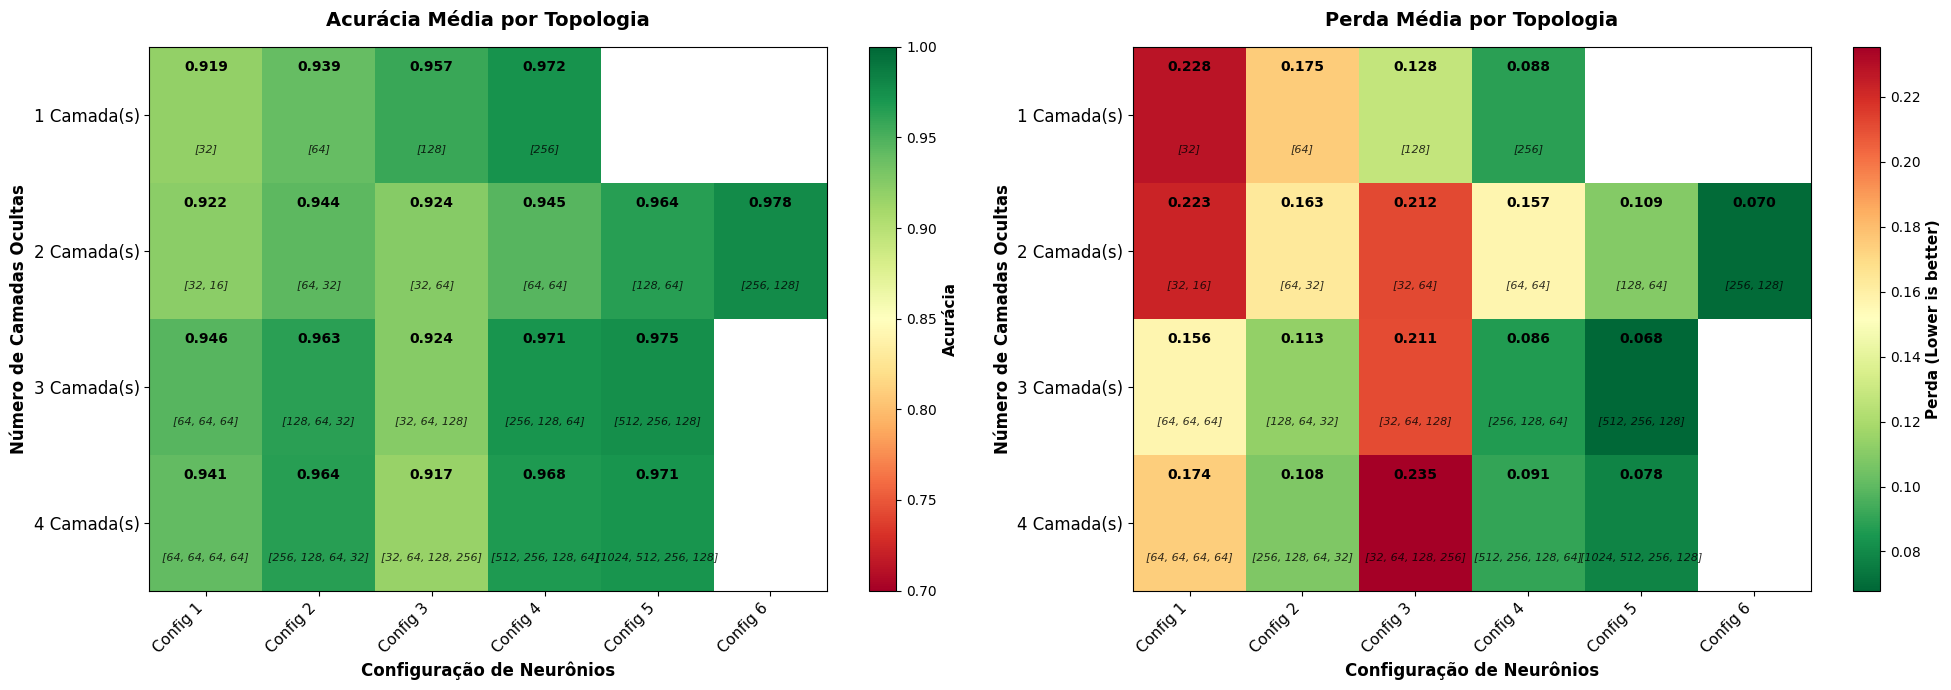

In [17]:
unique_num_hidden_layers = sorted(list({r['number of hidden layers'] for r in results_q3}))

# Para cada número de camadas, ordena as configurações de neurônios
# Como temos 3 opções por número de camadas, indexamos sequencialmente
configs_per_layers = {nh: [] for nh in unique_num_hidden_layers}
for r in results_q3:
    nh = r['number of hidden layers']
    nn = r['neurons per layer']
    if nn not in configs_per_layers[nh]:
        configs_per_layers[nh].append(nn)

# Ordena cada lista por tamanho crescente (total de neurônios)
for nh in configs_per_layers:
    configs_per_layers[nh].sort(key=lambda x: sum(x))

# Número máximo de configurações por número de camadas
max_configs = max(len(configs_per_layers[nh]) for nh in unique_num_hidden_layers)

# Matrizes para os mapas de calor
accuracy_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)
loss_matrix = np.full((len(unique_num_hidden_layers), max_configs), np.nan)


for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        match = [r for r in results_q3 if r['number of hidden layers'] == nh and r['neurons per layer'] == nn]
        if match:
            accuracy_matrix[i, j] = match[0]['accuracy_mean']
            loss_matrix[i, j] = match[0]['loss_mean']

#Labels dos gráficos
col_labels = []
for nh in unique_num_hidden_layers:
    for nn in configs_per_layers[nh]:
        col_labels.append(str(nn))

config_labels = [f"Config {j+1}" for j in range(max_configs)]

# Visualização dos mapas de calor - VERSÃO EXPANDIDA
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# MAPA DE ACURÁCIA
im0 = axes[0].imshow(accuracy_matrix, cmap='RdYlGn', aspect='auto', vmin=0.7, vmax=1.0)
axes[0].set_title('Acurácia Média por Topologia', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xticks(range(max_configs))
axes[0].set_xticklabels(config_labels, rotation=45, ha='right', fontsize=11)
axes[0].set_yticks(range(len(unique_num_hidden_layers)))
axes[0].set_yticklabels([f"{nh} Camada(s)" for nh in unique_num_hidden_layers], fontsize=12)
axes[0].set_xlabel('Configuração de Neurônios', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Camadas Ocultas', fontsize=12, fontweight='bold')

# Anota cada célula com valores em formato otimizado
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        acc_val = accuracy_matrix[i, j]
        if not np.isnan(acc_val):
            # Separa neurônios em múltiplas linhas se necessário
            neurons_str = str(list(nn))
            axes[0].text(j, i-0.35, f'{acc_val:.3f}', ha='center', va='center',
                        color='white' if acc_val < 0.85 else 'black',
                        fontsize=10, fontweight='bold')
            axes[0].text(j, i+0.25, neurons_str, ha='center', va='center',
                        color='white' if acc_val < 0.85 else 'black',
                        fontsize=8, style='italic', alpha=0.8)

cbar0 = plt.colorbar(im0, ax=axes[0], label='Acurácia')
cbar0.set_label('Acurácia', fontsize=11, fontweight='bold')

# MAPA DE PERDA
im1 = axes[1].imshow(loss_matrix, cmap='RdYlGn_r', aspect='auto')
axes[1].set_title('Perda Média por Topologia', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xticks(range(max_configs))
axes[1].set_xticklabels(config_labels, rotation=45, ha='right', fontsize=11)
axes[1].set_yticks(range(len(unique_num_hidden_layers)))
axes[1].set_yticklabels([f"{nh} Camada(s)" for nh in unique_num_hidden_layers], fontsize=12)
axes[1].set_xlabel('Configuração de Neurônios', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Número de Camadas Ocultas', fontsize=12, fontweight='bold')

# Anota cada célula com valores em formato otimizado
for i, nh in enumerate(unique_num_hidden_layers):
    for j, nn in enumerate(configs_per_layers[nh]):
        loss_val = loss_matrix[i, j]
        if not np.isnan(loss_val):
            # Separa neurônios em múltiplas linhas se necessário
            neurons_str = str(list(nn))
            axes[1].text(j, i-0.35, f'{loss_val:.3f}', ha='center', va='center',
                        color='white' if loss_val > 0.35 else 'black',
                        fontsize=10, fontweight='bold')
            axes[1].text(j, i+0.25, neurons_str, ha='center', va='center',
                        color='white' if loss_val > 0.35 else 'black',
                        fontsize=8, style='italic', alpha=0.8)

cbar1 = plt.colorbar(im1, ax=axes[1], label='Perda')
cbar1.set_label('Perda (Lower is better)', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Métricas

========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========


2. CURVAS DE CONVERGÊNCIA - Separadas por número de camadas


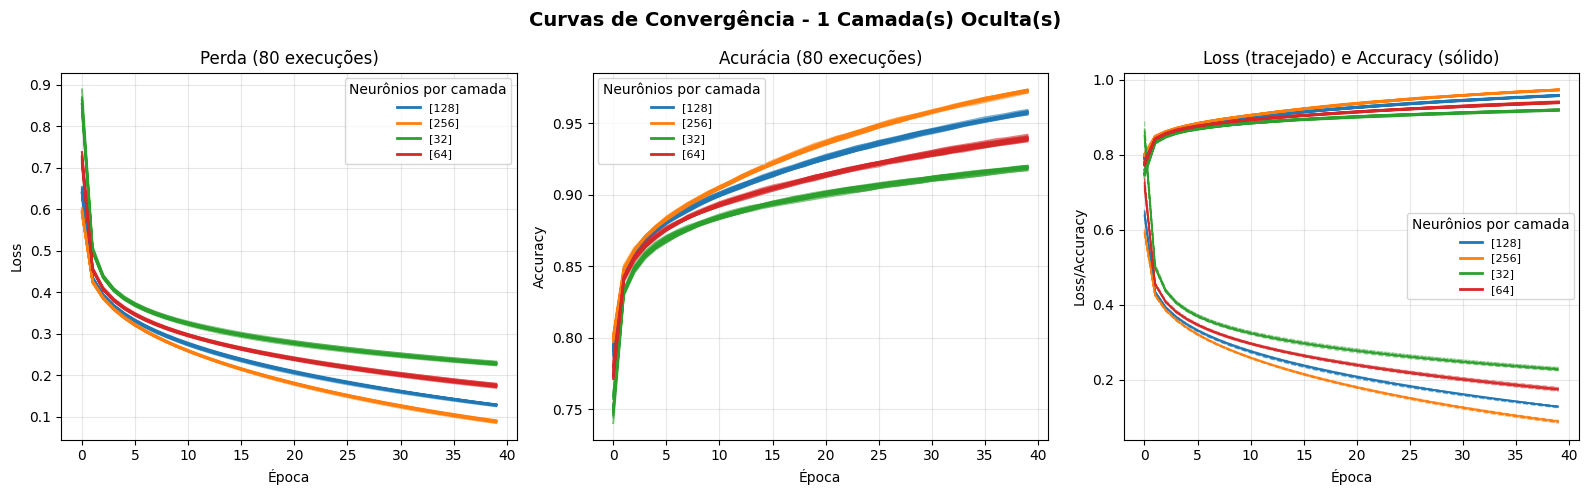


1 camada(s): 80 execuções
  Configuração [128]: 20 execução(ões)
  Configuração [256]: 20 execução(ões)
  Configuração [32]: 20 execução(ões)
  Configuração [64]: 20 execução(ões)


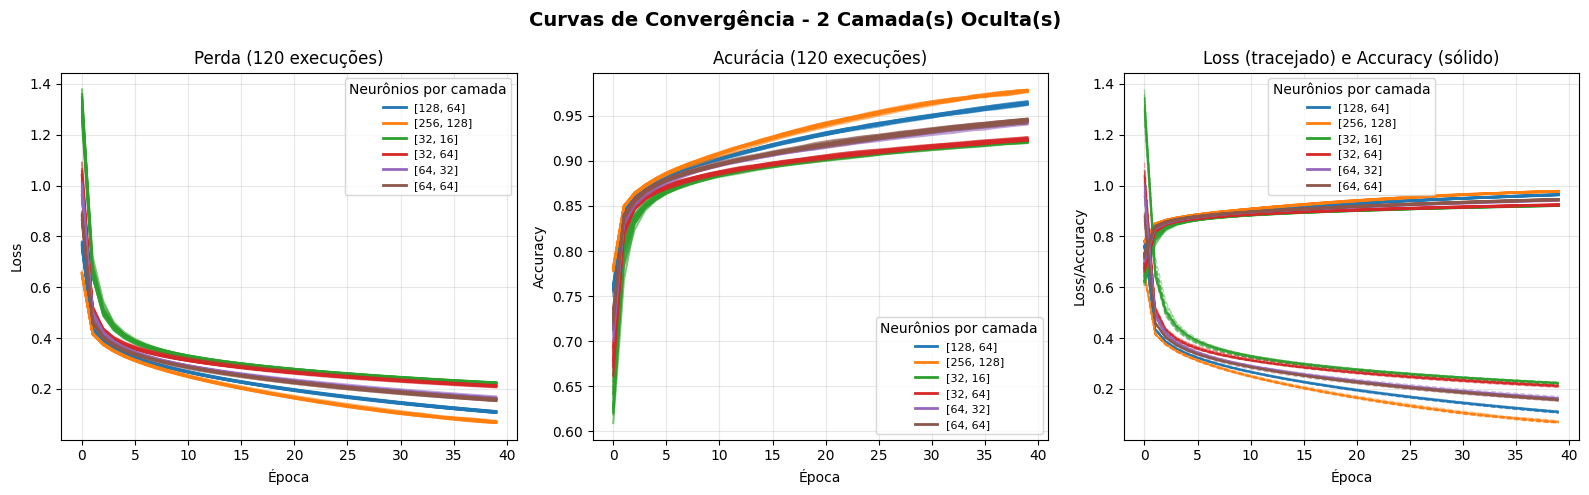


2 camada(s): 120 execuções
  Configuração [128, 64]: 20 execução(ões)
  Configuração [256, 128]: 20 execução(ões)
  Configuração [32, 16]: 20 execução(ões)
  Configuração [32, 64]: 20 execução(ões)
  Configuração [64, 32]: 20 execução(ões)
  Configuração [64, 64]: 20 execução(ões)


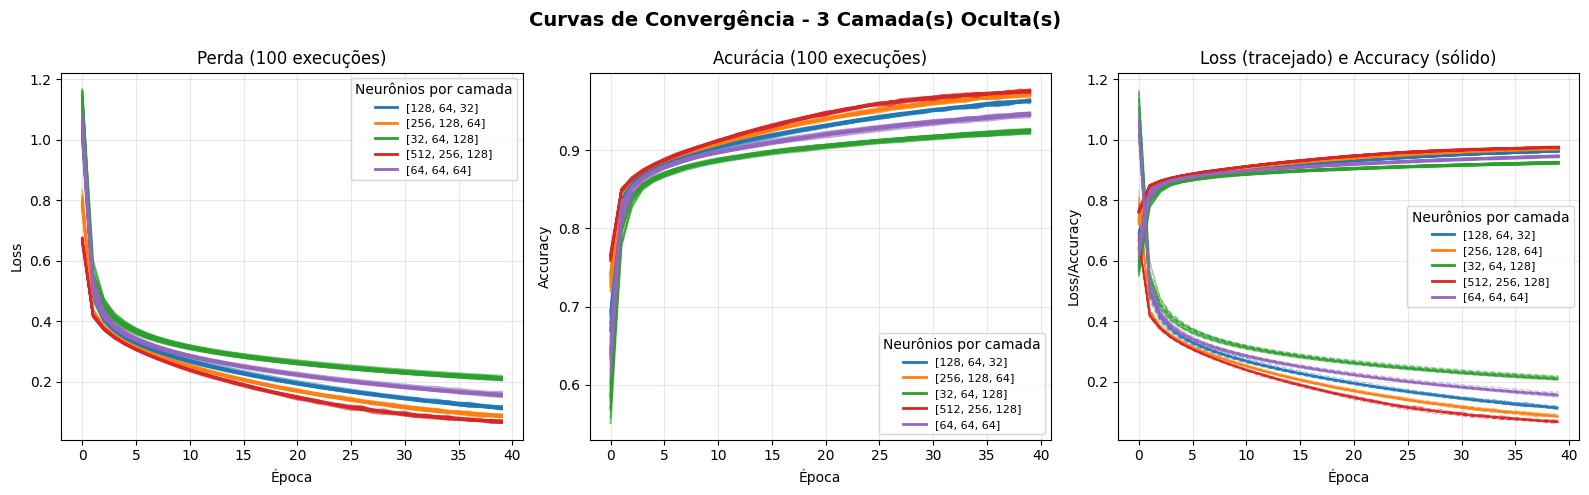


3 camada(s): 100 execuções
  Configuração [128, 64, 32]: 20 execução(ões)
  Configuração [256, 128, 64]: 20 execução(ões)
  Configuração [32, 64, 128]: 20 execução(ões)
  Configuração [512, 256, 128]: 20 execução(ões)
  Configuração [64, 64, 64]: 20 execução(ões)


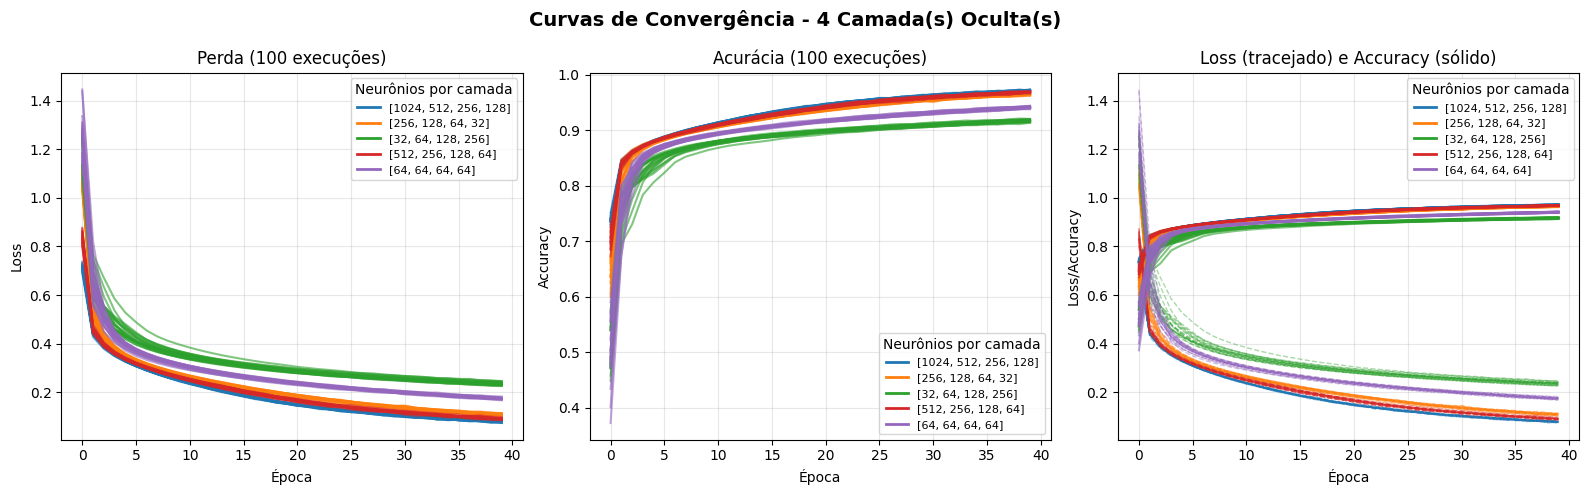


4 camada(s): 100 execuções
  Configuração [1024, 512, 256, 128]: 20 execução(ões)
  Configuração [256, 128, 64, 32]: 20 execução(ões)
  Configuração [32, 64, 128, 256]: 20 execução(ões)
  Configuração [512, 256, 128, 64]: 20 execução(ões)
  Configuração [64, 64, 64, 64]: 20 execução(ões)

2.5. CURVAS DE CONVERGÊNCIA - Todas as Topologias


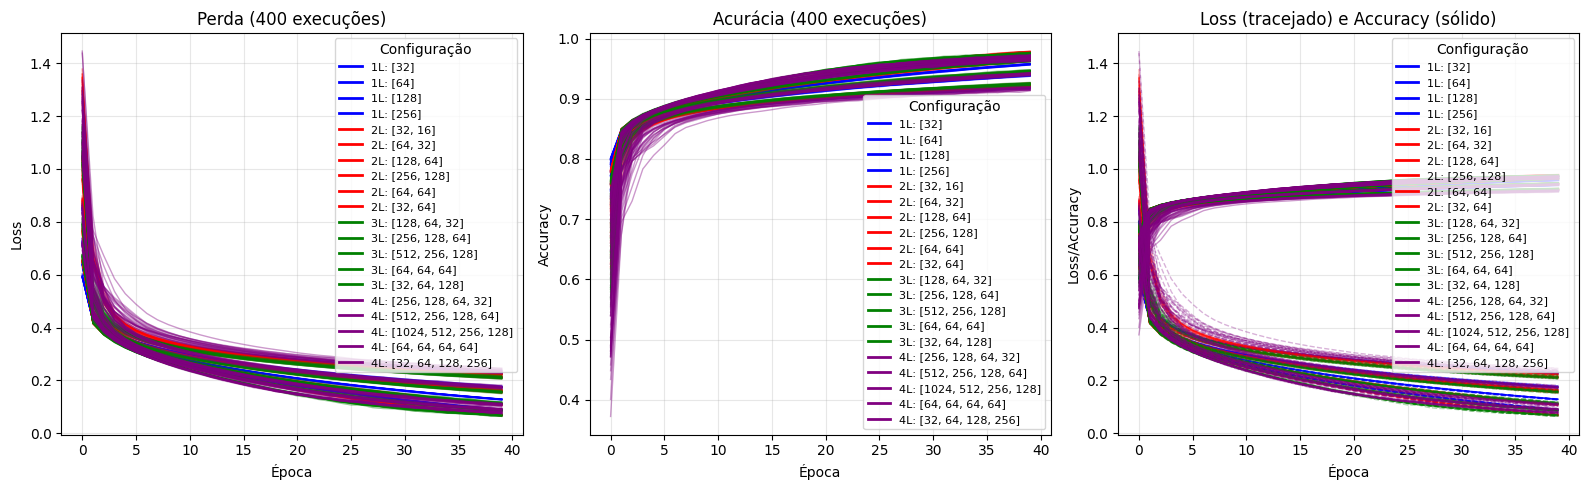


3. TEMPO DE TREINAMENTO


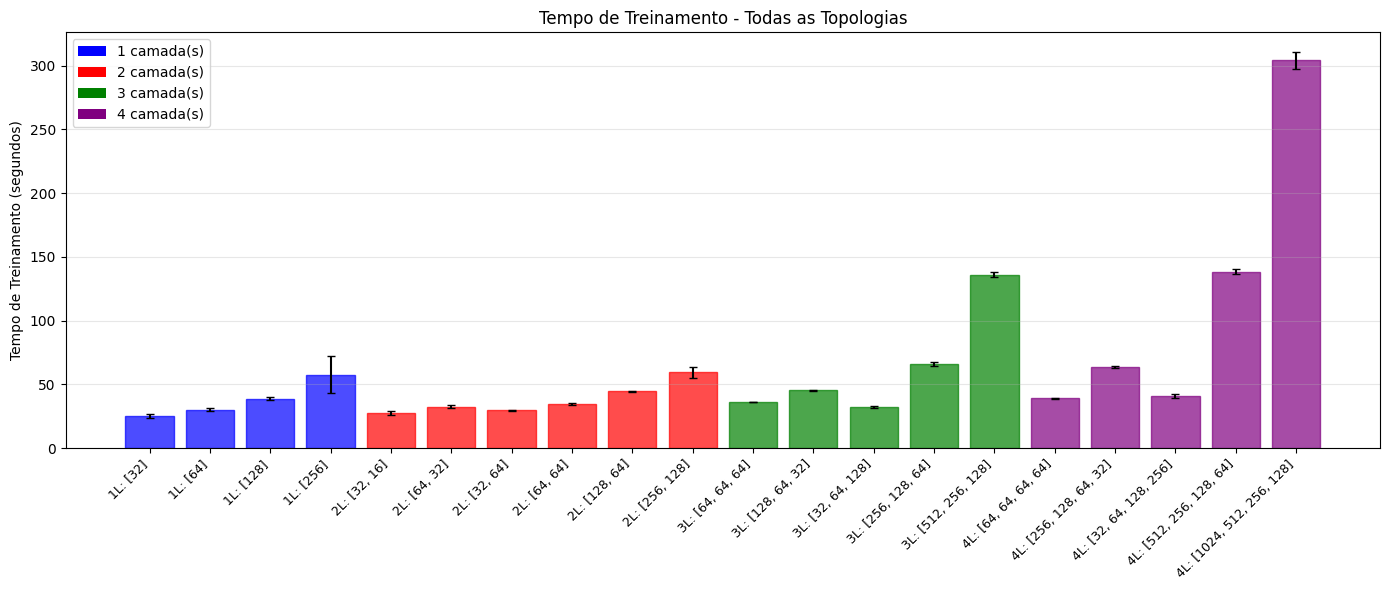


1 camada(s):
  [32]: Tempo = 25.19s (±1.34s)
  [64]: Tempo = 30.08s (±1.15s)
  [128]: Tempo = 38.78s (±1.28s)
  [256]: Tempo = 57.43s (±14.42s)

2 camada(s):
  [32, 16]: Tempo = 27.69s (±1.55s)
  [64, 32]: Tempo = 32.45s (±1.41s)
  [32, 64]: Tempo = 29.54s (±0.47s)
  [64, 64]: Tempo = 34.66s (±0.64s)
  [128, 64]: Tempo = 44.50s (±0.46s)
  [256, 128]: Tempo = 59.36s (±4.36s)

3 camada(s):
  [64, 64, 64]: Tempo = 36.24s (±0.20s)
  [128, 64, 32]: Tempo = 45.23s (±0.41s)
  [32, 64, 128]: Tempo = 32.21s (±0.52s)
  [256, 128, 64]: Tempo = 66.15s (±1.75s)
  [512, 256, 128]: Tempo = 136.09s (±2.21s)

4 camada(s):
  [64, 64, 64, 64]: Tempo = 38.88s (±0.76s)
  [256, 128, 64, 32]: Tempo = 63.86s (±0.69s)
  [32, 64, 128, 256]: Tempo = 40.66s (±1.65s)
  [512, 256, 128, 64]: Tempo = 138.46s (±2.22s)
  [1024, 512, 256, 128]: Tempo = 304.24s (±6.45s)

4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação


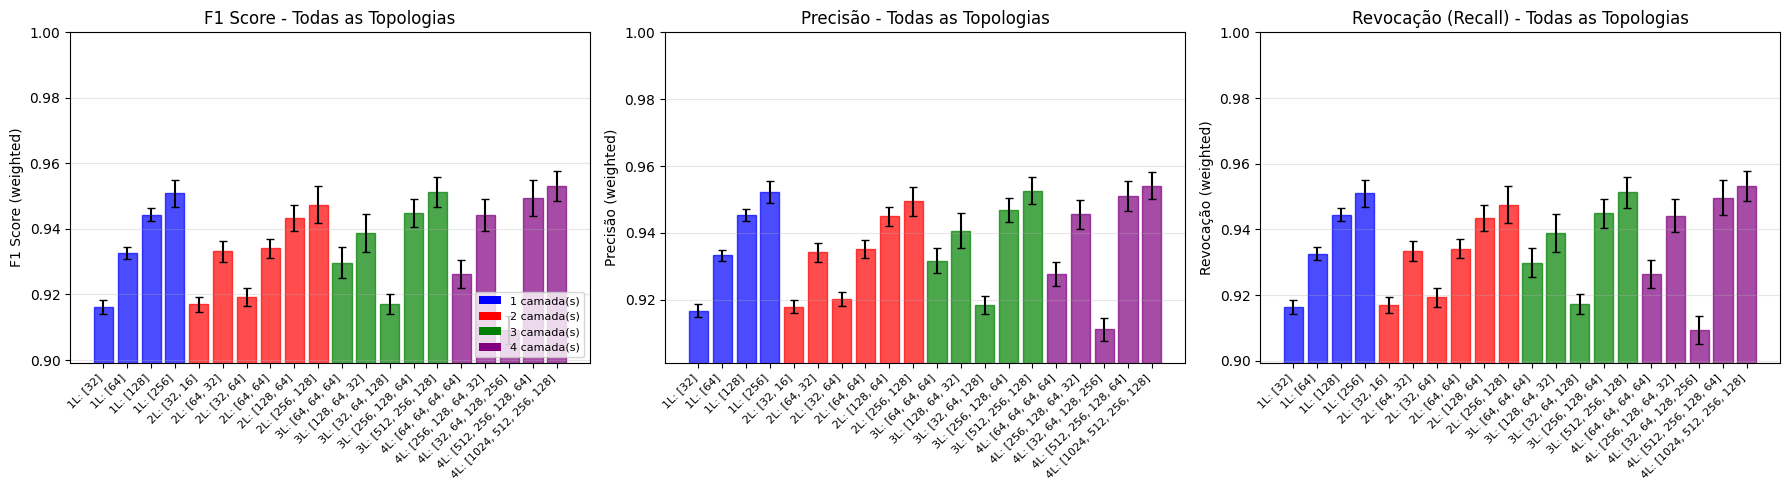

In [20]:
# Métricas da Questão 03: análise de todas as topologias testadas
# Métricas: função de perda, curva de convergência, tempo de treinamento, generalização (F1), precisão, revocação

print("========== ANÁLISE DE TODAS AS TOPOLOGIAS Q3 ==========\n")

# Organiza os resultados por número de camadas
results_by_layers = {}
for r in results_q3:
    nh = r['number of hidden layers']
    if nh not in results_by_layers:
        results_by_layers[nh] = []
    results_by_layers[nh].append(r)

# Ordena cada grupo por soma de neurônios
for nh in results_by_layers:
    results_by_layers[nh].sort(key=lambda x: sum(x['neurons per layer']))

# Cores para cada número de camadas (dinâmico para suportar qualquer número)
unique_layers = sorted(results_by_layers.keys())
colors_list_palette = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
colors_map = {nh: colors_list_palette[i % len(colors_list_palette)] for i, nh in enumerate(unique_layers)}
markers_map = {nh: ['o', 's', '^', 'd', 'v', '*', 'P', 'H'][i % 8] for i, nh in enumerate(unique_layers)}

# Prepara dados agregados
all_configs = []
all_losses = []
all_loss_stds = []
all_accuracies = []
all_acc_stds = []
all_times = []
all_time_stds = []
all_f1 = []
all_f1_stds = []
all_precision = []
all_precision_stds = []
all_recall = []
all_recall_stds = []
colors_list = []

for nh in sorted(results_by_layers.keys()):
    for r in results_by_layers[nh]:
        config_label = f"{nh}L: {r['neurons per layer']}"
        all_configs.append(config_label)
        all_losses.append(r['loss_mean'])
        all_loss_stds.append(r['loss_std'])
        all_accuracies.append(r['accuracy_mean'])
        all_acc_stds.append(r['accuracy_std'])
        all_times.append(r['time_mean'])
        all_time_stds.append(r['time_std'])
        all_f1.append(r['f1_mean'])
        all_f1_stds.append(r['f1_std'])
        all_precision.append(r['precision_mean'])
        all_precision_stds.append(r['precision_std'])
        all_recall.append(r['recall_mean'])
        all_recall_stds.append(r['recall_std'])
        colors_list.append(colors_map[nh])

x_pos = np.arange(len(all_configs))

# Legenda comum
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[nh], label=f'{nh} camada(s)')
                   for nh in sorted(colors_map.keys())]

# ========== 2. CURVAS DE CONVERGÊNCIA - POR NÚMERO DE CAMADAS ==========
print("\n2. CURVAS DE CONVERGÊNCIA - Separadas por número de camadas")

# Define cores distintas para cada configuração de neurônios
colors_neurons = plt.cm.tab10(np.linspace(0, 1, 10))

# Para cada número de camadas, cria um conjunto de 3 subplots
for num_layers in sorted(set([h['num_hidden_layers'] for h in histories_q3])):
    # Filtra históricos desta configuração de camadas
    layer_histories = [h for h in histories_q3 if h['num_hidden_layers'] == num_layers]

    # Organiza por configuração única de neurônios
    unique_configs = {}
    for h in layer_histories:
        config_key = str(h['neurons_per_layer'])
        if config_key not in unique_configs:
            unique_configs[config_key] = []
        unique_configs[config_key].append(h['history'])

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(f'Curvas de Convergência - {num_layers} Camada(s) Oculta(s)', fontsize=14, fontweight='bold')


    axes[0].set_title(f'Perda ({len(layer_histories)} execuções)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[0].plot(h.history['loss'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona label apenas uma vez por configuração
        axes[0].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[0].grid(True, alpha=0.3)


    axes[1].set_title(f'Acurácia ({len(layer_histories)} execuções)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[1].plot(h.history['accuracy'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona label apenas uma vez por configuração
        axes[1].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[1].grid(True, alpha=0.3)


    axes[2].set_title('Loss (tracejado) e Accuracy (sólido)')
    color_idx = 0
    for config_key, histories_list in sorted(unique_configs.items()):
        color = colors_neurons[color_idx % len(colors_neurons)]
        for h in histories_list:
            axes[2].plot(h.history['loss'], alpha=0.4, linewidth=1, color=color, linestyle='--')
            axes[2].plot(h.history['accuracy'], alpha=0.6, linewidth=1.5, color=color)
        # Adiciona labels
        axes[2].plot([], [], color=color, linewidth=2, label=config_key)
        color_idx += 1

    axes[2].set_xlabel('Época')
    axes[2].set_ylabel('Loss/Accuracy')
    axes[2].legend(title='Neurônios por camada', fontsize=8, loc='best')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n{num_layers} camada(s): {len(layer_histories)} execuções")
    for config_key in sorted(unique_configs.keys()):
        print(f"  Configuração {config_key}: {len(unique_configs[config_key])} execução(ões)")

print("\n2.5. CURVAS DE CONVERGÊNCIA - Todas as Topologias")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# Perda
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[0].plot(h['history'].history['loss'], alpha=0.4, linewidth=1, color=color)
    axes[0].plot([], [], color=color, linewidth=2, label=config_key)
axes[0].set_title(f'Perda ({len(histories_q3)} execuções)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend(title='Configuração', fontsize=8, loc='best')
axes[0].grid(True, alpha=0.3)
# Acurácia
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[1].plot(h['history'].history['accuracy'], alpha=0.4, linewidth=1, color=color)
    axes[1].plot([], [], color=color, linewidth=2, label=config_key)
axes[1].set_title(f'Acurácia ({len(histories_q3)} execuções)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend(title='Configuração', fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)
# Ambas
for r in results_q3:
    config_key = f"{r['number of hidden layers']}L: {r['neurons per layer']}"
    color = colors_map[r['number of hidden layers']]
    matching_histories = [h for h in histories_q3 if h['num_hidden_layers'] == r['number of hidden layers'] and h['neurons_per_layer'] == r['neurons per layer']]
    for h in matching_histories:
        axes[2].plot(h['history'].history['loss'], alpha=0.3, linewidth=1, color=color, linestyle='--')
        axes[2].plot(h['history'].history['accuracy'], alpha=0.4, linewidth=1, color=color)
    axes[2].plot([], [], color=color, linewidth=2, label=config_key)
axes[2].set_title('Loss (tracejado) e Accuracy (sólido)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Loss/Accuracy')
axes[2].legend(title='Configuração', fontsize=8, loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== 3. TEMPO DE TREINAMENTO ==========
print("\n3. TEMPO DE TREINAMENTO")
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(x_pos, all_times, yerr=all_time_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars):
    bar.set_color(colors_list[i])

ax.set_xticks(x_pos)
ax.set_xticklabels(all_configs, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Tempo de Treinamento (segundos)')
ax.set_title('Tempo de Treinamento - Todas as Topologias')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

for nh in sorted(results_by_layers.keys()):
    print(f"\n{nh} camada(s):")
    for r in results_by_layers[nh]:
        print(f"  {r['neurons per layer']}: Tempo = {r['time_mean']:.2f}s (±{r['time_std']:.2f}s)")

# ========== 4. GENERALIZAÇÃO (F1, PRECISÃO, REVOCAÇÃO) ==========
print("\n4. GENERALIZAÇÃO - Medida F1, Precisão e Revocação")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 Score
bars0 = axes[0].bar(x_pos, all_f1, yerr=all_f1_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars0):
    bar.set_color(colors_list[i])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[0].set_ylabel('F1 Score (weighted)')
axes[0].set_title('F1 Score - Todas as Topologias')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([min(all_f1) - 0.01, 1.0])
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

# Precisão
bars1 = axes[1].bar(x_pos, all_precision, yerr=all_precision_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars1):
    bar.set_color(colors_list[i])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('Precisão (weighted)')
axes[1].set_title('Precisão - Todas as Topologias')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([min(all_precision) - 0.01, 1.0])

# Revocação
bars2 = axes[2].bar(x_pos, all_recall, yerr=all_recall_stds, alpha=0.7, capsize=3)
for i, bar in enumerate(bars2):
    bar.set_color(colors_list[i])
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(all_configs, rotation=45, ha='right', fontsize=8)
axes[2].set_ylabel('Revocação (weighted)')
axes[2].set_title('Revocação (Recall) - Todas as Topologias')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([min(all_recall) - 0.01, 1.0])

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt

def treinar_avaliar_modelo(config, x_train, y_train, x_val, y_val, x_test=None, y_test=None, verbose=0):
    # 1. Configura seed e modelo
    keras.utils.set_random_seed(42)

    # Extrai configs ou usa padrões
    lr = config.get('learning_rate', 0.001)
    beta1 = config.get('beta1', 0.7)
    layers = config.get('layers', 2)
    neurons = config.get('neurons', [256, 128])
    epochs = config.get('epochs', 40)
    batch_size = config.get('batch_size', 64)
    activation_hidden = config.get('activation_hidden', 'relu')

    model = build_model(learning_rate=lr, beta1=beta1,
                        num_hidden_layers=layers, neurons_per_layer=neurons,
                        activation_hidden=activation_hidden)

    # 2. Callback Padrão
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 3. Treino
    start = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(x_val, y_val), callbacks=[es], verbose=verbose)
    tempo = time.time() - start

    # 4. Métricas finais
    results = {
        'history': history,
        'time': tempo,
        'epochs_run': len(history.history['loss']),
        'train_loss': history.history['loss'][-1],
        'val_loss': min(history.history['val_loss']),
        'val_acc': max(history.history['val_accuracy'])
    }

    # Predição para F1 score, precisão, recall no conjunto de validação
    y_val_pred_prob = model.predict(x_val, verbose=0)
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)
    report_val = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
    results.update({
        'val_f1': report_val['weighted avg']['f1-score'],
        'val_precision': report_val['weighted avg']['precision'],
        'val_recall': report_val['weighted avg']['recall'],
    })

    # 5. Avaliação no teste (usado na Q5 e Q6)
    if x_test is not None:
        y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
        report_test = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.update({
            'test_acc': report_test['accuracy'],
            'test_f1': report_test['weighted avg']['f1-score'],
            'test_precision': report_test['weighted avg']['precision'],
            'test_recall': report_test['weighted avg']['recall'],
            'test_loss': model.evaluate(x_test, y_test, verbose=0)[0]
        })

    return results

In [22]:
def plotar_curvas(histories, titulos):
    """Plota Loss e Acurácia para uma lista de históricos."""
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    if not isinstance(histories, list): histories = [histories]
    if not isinstance(titulos, list): titulos = [titulos]

    for h, titulo in zip(histories, titulos):
        dados = h.history if hasattr(h, 'history') else h
        # Loss
        ax[0].plot(dados['loss'], label=f'{titulo} (Treino)')
        if 'val_loss' in dados:
            ax[0].plot(dados['val_loss'], linestyle='--', label=f'{titulo} (Val)')
        # Acurácia
        ax[1].plot(dados['accuracy'], label=f'{titulo} (Treino)')
        if 'val_accuracy' in dados:
            ax[1].plot(dados['val_accuracy'], linestyle='--', label=f'{titulo} (Val)')

    ax[0].set_title('Perda (Loss)'); ax[0].legend(); ax[0].grid(True, alpha=0.3)
    ax[1].set_title('Acurácia'); ax[1].legend(); ax[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Questão 04
melhor modelo até o momento(desconsiderando velocidade de convergência):
- 2 camadas ocultas, com 256 e 128 neurônios
- batch size: 64
- beta1: 0.7
- learning rate: 0.001
- epochs: 20
- função de ativação: tanh

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

# ==============================================================================
# CONFIGURAÇÃO DA MELHOR TOPOLOGIA (Da Questão 3)
# ==============================================================================
MELHOR_NUM_CAMADAS = 2
MELHOR_NEURONIOS = [256, 128]
MELHOR_LR = 0.001       # Valor que obteve bom desempenho (Loss ~0.13)
MELHOR_BETA1 = 0.7
EPOCHS_FIXAS = 40
BATCH_SIZE_FIXO = 64

# ==============================================================================
# QUESTÃO 04: Influência da Quantidade de Dados
# ==============================================================================

# Frações do dataset para teste (10% a 100%)
fractions = [0.1, 0.3, 0.5, 0.7, 1.0]
results_q4 = []

print(f"=== INICIANDO QUESTÃO 4 ===")
print(f"Topologia Fixa: {MELHOR_NUM_CAMADAS} camadas ocultas {MELHOR_NEURONIOS}")
print(f"Hiperparâmetros: LR={MELHOR_LR}, Beta1={MELHOR_BETA1}, Epochs={EPOCHS_FIXAS}, Batch={BATCH_SIZE_FIXO}")
print(f"Testando frações: {fractions}\n")

for frac in fractions:
    # 1. Amostragem estratificada
    if frac == 1.0:
        x_subset, y_subset = x_train, y_train
    else:
        # Mantem a proporção das classes mesmo cortando os dados
        x_subset, _, y_subset, _ = train_test_split(
            x_train, y_train,
            train_size=frac,
            stratify=y_train,
            random_state=42
        )

    n_samples = len(x_subset)
    print(f"> Treinando com {int(frac * 100)}% dos dados ({n_samples} amostras)...")

    # 2. Configurações para a função treinar_avaliar_modelo
    config_q4 = {
        'learning_rate': MELHOR_LR,
        'beta1': MELHOR_BETA1,
        'layers': MELHOR_NUM_CAMADAS,
        'neurons': MELHOR_NEURONIOS,
        'epochs': EPOCHS_FIXAS, # Passa o número de épocas da Q4
        'batch_size': BATCH_SIZE_FIXO # Passa o batch size da Q4
    }

    # 3. Treinar e avaliar o modelo usando a função utilitária
    # Passa x_test e y_test para que a função já calcule as métricas de teste
    metrics = treinar_avaliar_modelo(config_q4, x_subset, y_subset, x_val, y_val, x_test=x_test, y_test=y_test, verbose=0)

    # 4. Coleta métricas do resultado
    results_q4.append({
        'fraction': frac,
        'samples': n_samples,
        'time': metrics['time'],
        'train_loss': metrics['train_loss'],
        'val_loss': metrics['val_loss'],
        'val_acc': metrics['val_acc'],
        'val_f1': metrics['val_f1'],
        'test_acc': metrics['test_acc']
    })

    print(f"  Tempo: {metrics['time']:.1f}s | Val Acc: {metrics['val_acc']:.4f} | Val Loss: {metrics['val_loss']:.4f}")


# ==============================================================================
# VISUALIZAÇÃO DOS RESULTADOS
# ==============================================================================

sizes = [r['samples'] for r in results_q4]
val_accs = [r['val_acc'] for r in results_q4]
train_losses = [r['train_loss'] for r in results_q4]
val_losses = [r['val_loss'] for r in results_q4]
times = [r['time'] for r in results_q4]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# 1. Curva de aprendizado
ax[0].plot(sizes, val_accs, 'o-', label='Validação', color='tab:blue')
ax[0].set_title('Impacto do Tamanho do Dataset na Acurácia')
ax[0].set_xlabel('Número de Exemplos')
ax[0].set_ylabel('Acurácia')
ax[0].grid(True, alpha=0.3)

# 2. Curva de loss (treino vs validação) - identifica overfitting em poucos dados
ax[1].plot(sizes, train_losses, 'o-', label='Treino', color='tab:orange')
ax[1].plot(sizes, val_losses, 's--', label='Validação', color='tab:red')
ax[1].set_title('Convergência de Loss (Treino vs Validação)')
ax[1].set_xlabel('Número de Exemplos')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Custo computacional
ax[2].plot(sizes, times, 'o-', color='purple')
ax[2].set_title('Tempo de Treinamento')
ax[2].set_xlabel('Número de Exemplos')
ax[2].set_ylabel('Tempo (s)')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela final
print("\nRESUMO DOS RESULTADOS (QUESTÃO 4):")
print(f"{'Dados(%)':<10} | {'Amostras':<10} | {'Tempo(s)':<10} | {'Val Acc':<10} | {'Val F1':<10}")
print("-" * 65)
for r in results_q4:
    print(f"{r['fraction']*100:<10.0f} | {r['samples']:<10} | {r['time']:<10.2f} | {r['val_acc']:<10.4f} | {r['val_f1']:<10.4f}")

In [ ]:
# Questão 5

In [ ]:
def load_checkpoint(checkpoint_file, q_name):
    checkpoint_file = Path(checkpoint_file)
    if checkpoint_file.is_file():
        print("\n✓ Carregando checkpoint anterior...")
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        results = checkpoint[f'results_{q_name}']
        histories = checkpoint[f'histories_{q_name}']
        start_combo = checkpoint['last_combination']
        if start_combo > 0:
            print(f"  Retomando de {start_combo} combinações já processadas")
    else:
        results = []
        histories = []
        start_combo = 0
    return results, histories, start_combo

In [ ]:
# Questão 6

In [ ]:
def save_checkpoint(checkpoint_file, results, histories, current_combination, start_combo, total_combinations, q_name=None, checkpoint_interval=5):
    checkpoint_file = Path(checkpoint_file)
    
    # Detectar nome da questão pelo caminho do arquivo se não fornecido
    if q_name is None:
        q_name = checkpoint_file.stem.split('_')[2] if '_' in checkpoint_file.stem else 'unknown'
    
    if current_combination % checkpoint_interval == 0 or current_combination == total_combinations:
        gc.collect()
        checkpoint_data = {
            f'results_{q_name}': results,
            f'histories_{q_name}': histories,
            'last_combination': current_combination
        }
        with open(checkpoint_file, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        
        # Estimar tempo remaining
        if len(results) >= 10:
            tempo_decorrido = (current_combination - start_combo) * 20 * np.mean([r.get('time_mean', 0) for r in results[-10:] if isinstance(r, dict) and 'time_mean' in r]) / 3600
        else:
            tempo_decorrido = 0
            
        print(f"✓ Checkpoint #{current_combination // checkpoint_interval} | Progresso: {current_combination}/{total_combinations} ({current_combination/total_combinations*100:.1f}%) | Tempo: ~{tempo_decorrido:.1f}h")